# Starter code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math
#from tensorflow.keras.optimizers import Adam
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import GRU
#from keras.layers import ReLU
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

#% matplotlib inline

#import plotly.offline as py
#import plotly.figure_factory as ff
#import plotly.graph_objs as go
from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;

#py.init_notebook_mode(connected=True)

#py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

#from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
#list_of_companies_number = ['1080']
#list_of_companies_number = ['13113']

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
len(list_of_companies_number)

99

In [4]:
help_time = []

In [5]:
#shape = [(nr of company, every possible timeslot from 8.01 till 16.30, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 
#data =  np.zeros(shape = (100, 5100,3)) 

In [6]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    five_best_bids_and_asks = np.zeros(shape = (2,2,5))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        five_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        five_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return five_best_bids_and_asks

In [7]:
def calc_semi_var(elements):
    mean = np.mean(elements)
    semi_var = 0
    for i in elements:
        if i<mean:
            semi_var += (mean-i)**2
    return semi_var

In [8]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [9]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [10]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [11]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [12]:
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [13]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute+1, 0
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [14]:
def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [15]:
def get_order_inbalance(record): #single company
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result

Reading data from files

In [16]:

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [17]:
# open file in read mode
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<=30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [18]:
# open file in read mode
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [19]:
data.shape
trades.shape

(99, 10)

# Plot of sweep to fill costs of company nr 1080 (Exhibit 1)

In [20]:
bid_and_ask_through_day = data[98][:510]

In [21]:
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))

In [22]:
for i in range(510):
    mid_prices[i] = get_mid_price(bid_and_ask_through_day[i])
    true_prices[i] = get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i][j] = get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j], true_prices[i])

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000


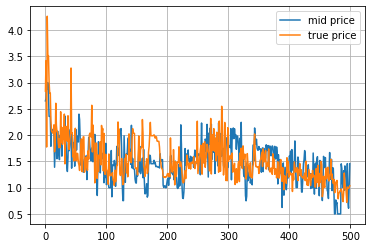

In [23]:
plt.plot(np.arange(500), average_fill_prices[10:,4]-mid_prices[10:])
plt.plot(np.arange(500), average_fill_prices[10:,4]-true_prices[10:])
plt.grid()
plt.legend(['mid price', 'true price'])

mid price


Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

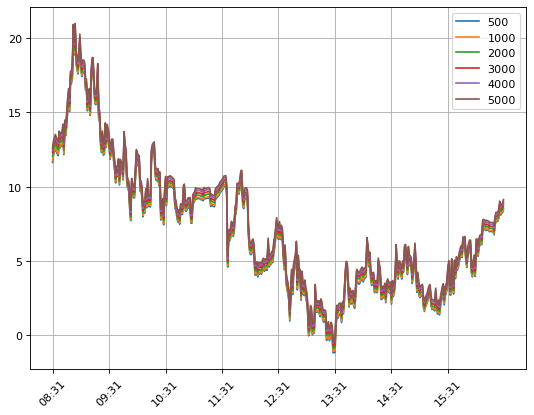

In [24]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    mid_prices[i%510] += get_mid_price(bid_and_ask_through_day[i])
    curr_mid_price =  get_mid_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_mid_price)
for i in range(510):
    mid_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
mid_prices = apply_moving_average(np.copy(mid_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

true price

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

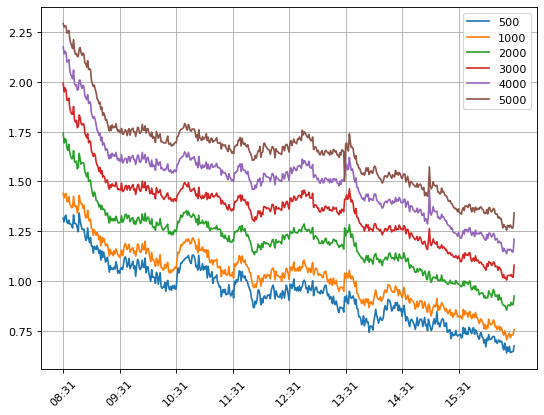

In [25]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    true_prices[i%510] += get_true_price(bid_and_ask_through_day[i])
    curr_true_price =  get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_true_price)
for i in range(510):
    true_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
true_prices = apply_moving_average(np.copy(true_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

In [26]:
bid_and_ask_through_day[0]

array([[[1582., 1580., 1579., 1576., 1575.],
        [1377.,  500., 1044., 8009.,  766.]],

       [[1588., 1589., 1591., 1592., 1596.],
        [1149.,   53., 1036.,  500., 4222.]]])

In [27]:
order_inbalance_one_day=get_order_inbalance(data[0][:510])

Plotting Bid, ask and true market prices(exhibit 6)

In [28]:
mid_price_one_day=np.zeros(510)
true_price_one_day=np.zeros(510)

for i in range (0,510):
    mid_price_one_day[i]=get_mid_price(data[0][i])
    true_price_one_day[i]=get_true_price(data[0][i])

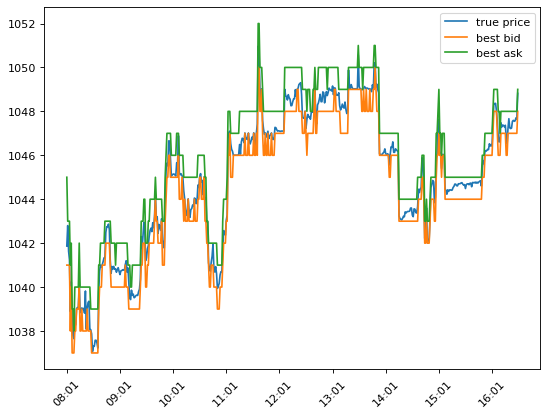

In [29]:
figure(figsize=(8, 6), dpi=80)

#plt.plot(np.arange(510), order_inbalance_one_day)#, mid_price_one_day)

#plt.plot(np.arange(510),  mid_price_one_day)
plt.plot(np.arange(510),  true_price_one_day)
plt.plot(np.arange(510),  data[0,:510,0,0,0])
plt.plot(np.arange(510),  data[0,:510,1,0,0])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x)) for x in np.arange(510, step=60)])
plt.xticks(ticks=np.arange(510, step=60), labels=x_axis, rotation=45)
plt.legend(['true price', 'best bid', 'best ask'])

Plotting Sweep to Fill Costs vs Order Size (exhibit 8 and 9)?????

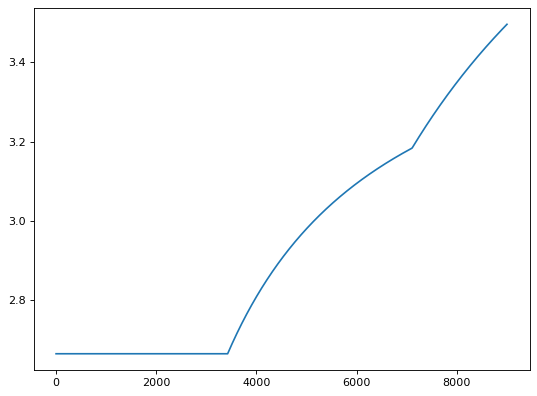

In [30]:
figure(figsize=(8, 6), dpi=80)
#bid_and_ask_through_first_two_hours = data[80][:120]
order_sizes_limit = 9000
true_price = get_true_price(data[80][40])
average_fill_prices = np.zeros(shape = (order_sizes_limit))
for i in range(1,order_sizes_limit+1):
    average_fill_prices[i-1] = get_sweep_to_fill_price(data[80][40], i,true_price)
plt.plot(average_fill_prices-true_price)

In [31]:
data[80][40]

array([[[1640., 1639., 1638., 1637., 1636.],
        [1715., 5727., 2576., 2830., 5163.]],

       [[1644., 1645., 1646., 1647., 1648.],
        [3425., 3681., 4334., 2581., 4997.]]])

In [32]:
order_inbalance_10_days=get_order_inbalance(data[1])
mid_price_10_days=[get_mid_price(data[1][i]) for i in range (0, 5100)]

In [33]:
company=90
order_inbalance_10_days=[round(i, 1) for i in get_order_inbalance(data[company])]
mid_price_10_days=np.asarray([get_mid_price(data[company][i]) for i in range (5100)])
price_diff=mid_price_10_days[:5099]-mid_price_10_days[1:]
inbalance_averageprice={}
for i in range(len(price_diff)):
    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    else:
        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
for k in inbalance_averageprice.keys():
    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

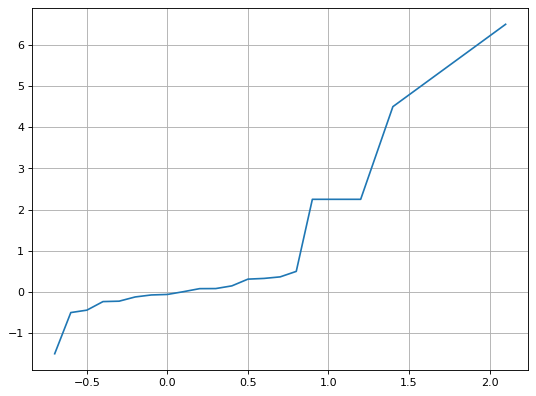

In [34]:
inbalance_averageprice_array=np.sort( np.asarray([[k, v] for k,v in inbalance_averageprice.items()]), axis=0)
figure(figsize=(8, 6), dpi=80)

plt.plot(inbalance_averageprice_array[5:,0], inbalance_averageprice_array[5:,1])

plt.grid()

In [35]:
inbalance_averageprice_array.shape

(25, 2)

Exhibit 17 -> Market impact for E-mini S&P Futures on a Typical Day (how to calculate true price after market impact???)

Unable to fill an order 5000
Unable to fill an order 2500
Unable to fill an order 5000
Unable to fill an order 5000


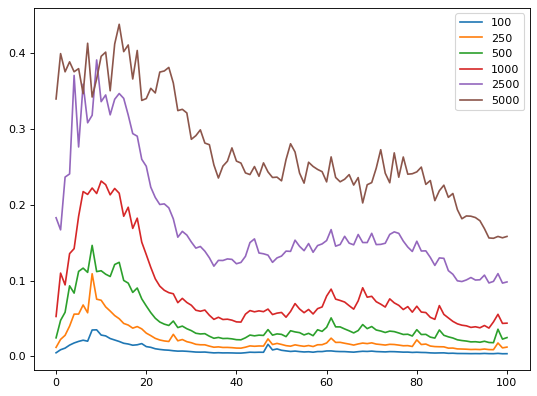

In [36]:
company_id = 15
order_sizes = [100, 250, 500, 1000, 2500, 5000]
num_of_timestamps = int((5100/5)-1)
modulo = int(510/5-1)
differences_in_prices = np.zeros(shape = (modulo, 6))
for i in range(num_of_timestamps):
    for order_size_ind in range(len(order_sizes)):
        price_before = get_true_price(np.copy(data[company_id][i*5]))
        price_after = get_true_price_after_sweep_to_fill(np.copy(data[company_id][i*5]), order_sizes[order_size_ind], price_before)
        differences_in_prices[i%modulo][order_size_ind] += abs(price_after - price_before)
figure(figsize=(8, 6), dpi=80)
for i in range(modulo):
    differences_in_prices[i]/=10
for k in range(len(order_sizes)):
    plt.plot(np.arange(modulo), apply_moving_average(np.copy(differences_in_prices[:,k]), 3))
plt.legend( order_sizes)
    

# Exhibit 3&4


In [37]:
comp_id=1
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
order_inbalance_comp=np.empty(shape=order_book_comp.shape[:2])
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]
    order_inbalance_comp[i]=get_order_inbalance(order_book_comp[i])

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time
time_to_next_trade=np.empty(shape=order_inbalance_comp.shape)

In [38]:
time_to_next_trade.shape

(10, 510)

In [39]:
trades[0].shape

(10,)

In [40]:
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        #print("XD", book_counter)
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        trade_time_tuple=trades_time_comp[day][trade_counter][2]
        time_to_next_trade[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
        # time to next trade given in seconds


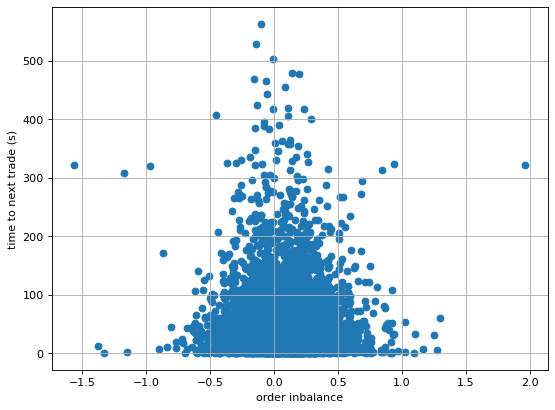

In [41]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='order inbalance', ylabel='time to next trade (s)')
plt.scatter(order_inbalance_comp.flatten(), time_to_next_trade.flatten())
plt.grid()
plt.show()

In [42]:
next_trades_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        next_trade_price=trades_time_comp[day][trade_counter][0]
        next_trades_prices[day, book_counter]=next_trade_price
        # time to next trade given in seconds

In [43]:
mid_market_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(order_book_comp.shape[0]):
    for record in range(order_book_comp.shape[1]):
        mid_market_prices[day, record]=get_mid_price(order_book_comp[day, record])

In [44]:
for day in range(mid_market_prices.shape[0]):
    for record in range(mid_market_prices.shape[1]):
        if mid_market_prices[day,record]==0:
            print(day, record)

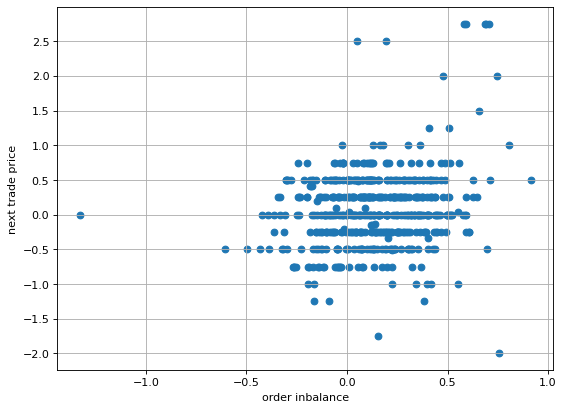

In [45]:
figure(figsize=(8, 6), dpi=80)
day=5
plt.axes(xlabel='order inbalance', ylabel='next trade price')
plt.scatter(order_inbalance_comp[day].flatten(), (next_trades_prices-mid_market_prices)[day].flatten())
max_next_trade_price=max((next_trades_prices-mid_market_prices)[day].flatten())
min_next_trade_price=min((next_trades_prices-mid_market_prices)[day].flatten())
plt.yticks(ticks=np.arange(start=min_next_trade_price, stop=max_next_trade_price, step=0.5))
plt.grid()
plt.show()

# Exhibit 11&12


In [46]:
interval=1
comp_id=3
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time

timestamps=510//interval
# buys on even, sells on odd
vwaps=np.zeros(shape=(10,2*timestamps)) 
order_sizes=np.zeros(shape=(10,2*timestamps))
#vwaps_sells=np.zeros(shape=(10,timestamps))
#order_sizes_sells=np.zeros(shape=(10,timestamps))



In [47]:
empty_orders=0
for day in range(vwaps.shape[0]):
    trade_counter=0
    for counter in range(vwaps.shape[1]//2):
        true_price=get_true_price(order_book_comp[day,counter])
        time_tuple=index_to_time(interval*(counter+1))
        buys=[]
        sells=[]
        buys_weights=[]
        sells_weights=[]
        while time_tuple>trades_time_comp[day][trade_counter][2]:
            if true_price<trades_time_comp[day][trade_counter][0]:
                buys.append(trades_time_comp[day][trade_counter][0])
                buys_weights.append(trades_time_comp[day][trade_counter][1])
            else:
                sells.append(trades_time_comp[day][trade_counter][0])
                sells_weights.append(trades_time_comp[day][trade_counter][1])               
            trade_counter+=1
            
        # in case there were no sells or buys during the interval            
        try:
            buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
        except:
            buys_avg=true_price
            buys_vol=0
            empty_orders+=1
        try:
            sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
        except:
            sells_avg=true_price
            sells_vol=0
            empty_orders+=1
        if sells_vol>10000 or buys_vol>10000:
            continue 
        vwaps[day,2*counter]=buys_avg-true_price
        vwaps[day,2*counter +1]=true_price-sells_avg
        order_sizes[day,2*counter]=buys_vol
        order_sizes[day,2*counter +1]=sells_vol
print('{}% of intervals were empty'.format(100*empty_orders/(10*2*timestamps)))

64.42156862745098% of intervals were empty


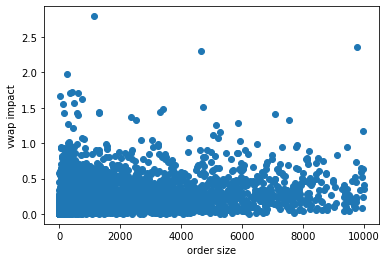

In [48]:
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes.flatten(), vwaps.flatten())

In [49]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#np.unique(stacked_vwaps_sizes, return_counts=True)

In [50]:
np.sort(np.array([[1,2],[1,4],[1,3]]), axis=0)

array([[1, 2],
       [1, 3],
       [1, 4]])

In [51]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#for x in  stacked_vwaps_sizes:#[:,0]
 #   if x[0]:
  #      print(x)

In [52]:
np.unique(order_sizes, return_counts=True)[1][0]

7060

In [53]:
np.unique(vwaps, return_counts=True)[1][0]

7060

In [54]:
vwaps[0].shape

(1020,)

**Exhibit 15 & 16**

In [55]:
company_id = 0
how_many_days = trades[company_id].shape[0]
num_of_five_min_buck = (7*60+2*30)//5
trading_volume_in_buckets = np.zeros(num_of_five_min_buck)
open_hour = 8
open_min = 30
end_hour = 16
end_min = 30
min_prices_in_buckets = np.ones(num_of_five_min_buck) * 10000000.0
max_prices_in_buckets = np.zeros(num_of_five_min_buck)

In [56]:
for i in range(10): #for every day
    for trade in trades[company_id][i]:
        trade_time = trade[2]
        trade_hour = trade_time[0]
        trade_min = trade_time[1]
        if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
            #print(trade)
            #print(trade_hour<open_hour)
            #print(trade_hour==open_hour and trade_min<open_min)
            #print(trade_hour==end_hour and trade_min>end_min)
            #print(trade_hour)
            #print(end_hour)
            #print(trade_hour>end_hour)
            continue
        which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//5
        min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
        max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
        trading_volume_in_buckets[which_bucket] += trade[1]
trading_volume_in_buckets/=10 #we take average of all days

In [57]:
price_volatility_in_buckets = max_prices_in_buckets - min_prices_in_buckets

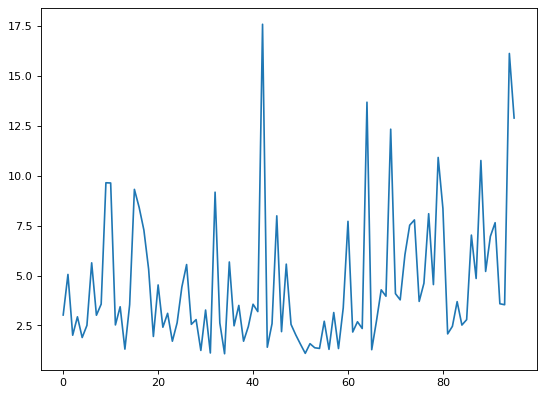

In [58]:
figure(figsize=(8, 6), dpi=80)

plt.plot(trading_volume_in_buckets/1000)

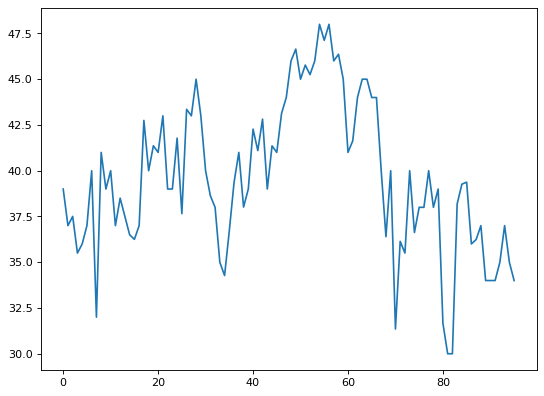

In [59]:
figure(figsize=(8, 6), dpi=80)
plt.plot(price_volatility_in_buckets)

# plot ORDER_IMPACT & VWAP


In [60]:
def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]
    result=np.zeros(timestamps//interval)
    for i in range (0,timestamps//interval):
        for j in range(interval):
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result

In [61]:
def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [62]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(vwaps.shape[0]):
        trade_counter=0
        for counter in range(vwaps.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(interval*(counter+1))
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
                sells_vol=math.nan
            if buys_vol>max_vol:
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return vwaps, order_sizes

In [63]:
np.average(np.arange(start=0, stop=11), weights=np.arange(11), returned=True)

(7.0, 55.0)

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


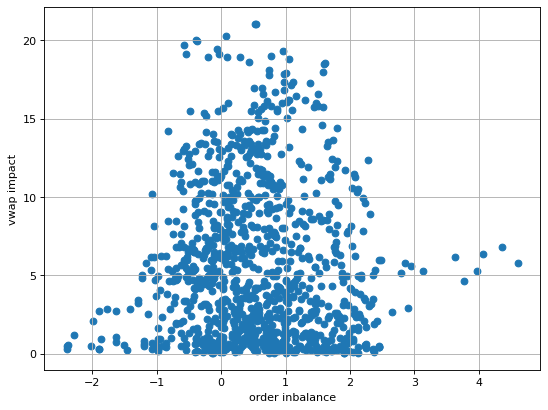

In [64]:
company=1
interval=5
time_to_skip=30
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)
order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='vwap impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
plt.grid()


In [65]:
order_inbalance.shape


(10, 96)

#  NEXTORDERX & S2FIMPACT

In [66]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=np.abs(next_trade_price-true_price) #abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError
    return next_trade_x

In [67]:
order_book_comp=np.empty(shape=(10, 510-30, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[0, 510*i+30:510*(i+1)]
get_true_price(order_book_comp[1, 4])

1044.0542079729794

In [68]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [69]:
get_sweep_to_fill_price(data[0, 965], 40137, get_true_price(data[0, 965]), sweep_buys=False)

1051.0469392331265

In [70]:
get_true_price(data[0, 965])

1048.9780872414447

In [71]:
data[0, 965]

array([[[ 1048.,  1047.,  1046.,  1045.,  1044.],
        [ 9552., 16964., 14256.,  8836., 11223.]],

       [[ 1050.,  1051.,  1052.,  1053.,  1054.],
        [ 9980., 18293., 14908.,  7544., 12958.]]])

21.515151515151516% of intervals were SELL empty
27.828282828282827% of intervals were BUY empty
20.606060606060606% of intervals were SELL empty
26.565656565656564% of intervals were BUY empty


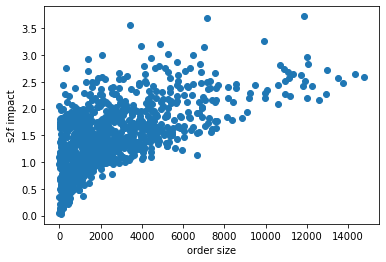

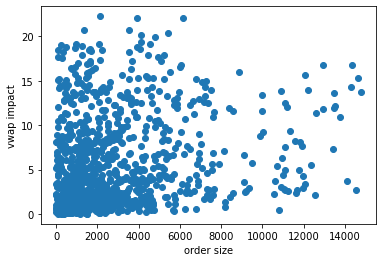

In [72]:
company_id=98
interval=5
time_to_skip=15

s2f_impacts, order_sizes_s2f=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwaps, order_sizes_vwaps=get_vwap_and_ordersizes_comp(company_id, interval, time_to_skip, max_vol=np.max(order_sizes_s2f.flatten()))

plt.axes(xlabel='order size', ylabel='s2f impact')
plt.scatter(order_sizes_s2f.flatten(), s2f_impacts.flatten())
plt.show()
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes_vwaps.flatten(), vwaps.flatten())
plt.show()

22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


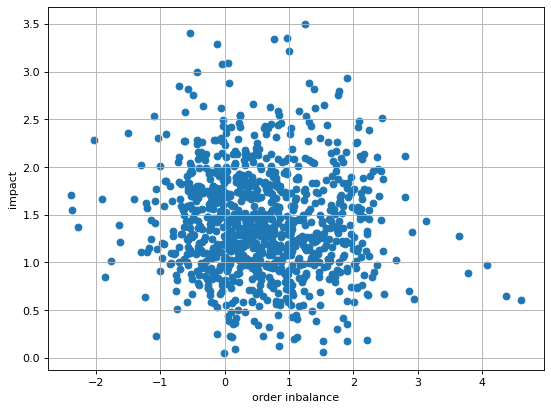

In [73]:
company=1
interval=5
time_to_skip=30
s2f_impacts, _=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)

order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), s2f_impacts)
#plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
#plt.legend(['s2f', 'vwap'])
plt.grid()

# TRUE&MID PRICE


In [74]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp
def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [75]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [76]:
get_price_change_comp(interval=5, time_to_skip=30).shape

(10, 96)

In [77]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('zly shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

# HEATMAP

In [78]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,30,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [79]:
def get_trading_volume_and_price_volatility_bula(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (8*60+30-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    open_hour = 8
    open_min = 0
    end_hour = 16
    end_min = 30
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            trade_hour = trade_time[0]
            trade_min = trade_time[1]
            if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
                continue
            which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//interval
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [80]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


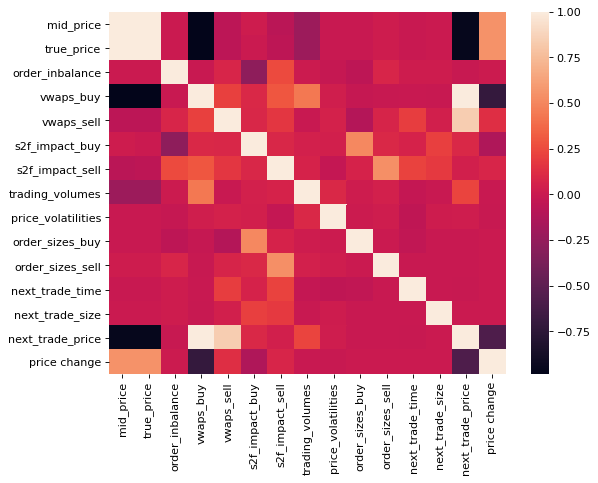

In [81]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='pearson'))
plt.show()

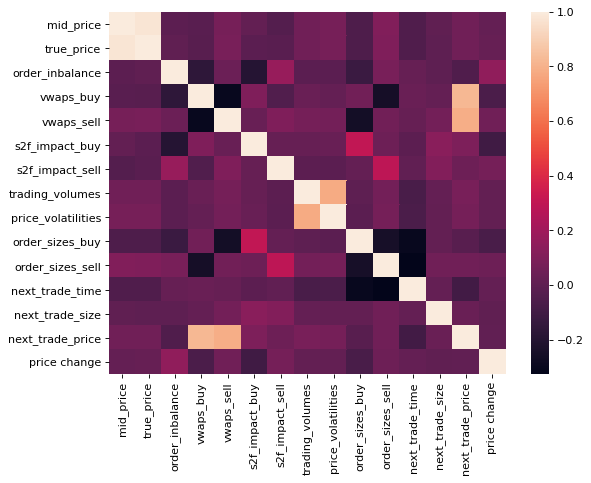

In [82]:
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

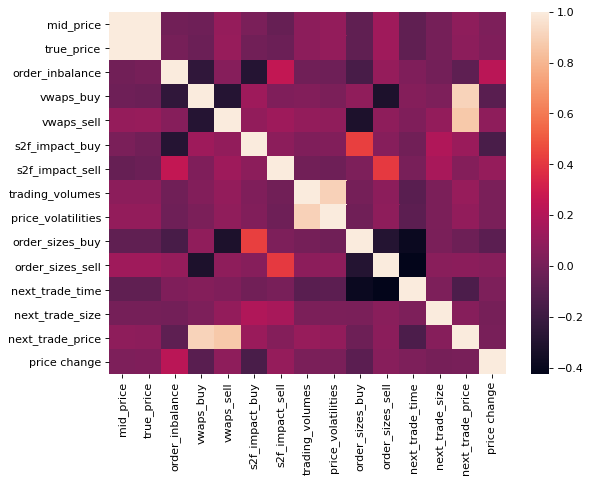

In [83]:
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(df.corr(method='spearman'))
plt.show()

# LOGISTIC REGRESSION

In [84]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures


In [85]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
    rolled_records = np.roll(records, past, axis = 1)
    rolled_records = rolled_records[:,past:]
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            elements_in_past = np.copy(records[day][buck:buck+past])
            count_elem = 0.0
            sum_elem = 0.0
            for i in range(len(elements_in_past)):
                if math.isnan(elements_in_past[i]):
                    elements_in_past[i] = 0
                else:
                    sum_elem+=elements_in_past[i]
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [86]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


In [87]:
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [88]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = 1
            else:
                res[i][j]=0
    #print(true_prices)
    #print(res)
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=threshold: # price swing >= than threshold % of price
                res[i][j] = 1
            else:
                res[i][j]=0

    return res

In [89]:
xd = get_true_price_comp(1, 5, 0)
print(xd[0])
print("ELDOO")
print(get_y_to_test_max_bool(xd, 60, 5)[0])

[871.14150943 872.93830598 870.92605887 872.91324752 877.23645902
 874.80857143 873.97417707 874.77054292 878.47576887 878.16017316
 875.57692308 874.88997821 873.2161157  875.30665533 874.82089852
 872.84275921 873.16297705 872.64643603 868.86053535 870.49203242
 869.35277896 869.5461934  872.01084746 875.64476331 875.45639891
 877.         876.96293888 876.43243961 876.22871365 877.12225406
 879.17233951 879.43232803 881.19458128 882.66666667 883.90151422
 885.58878849 886.27205716 886.03702532 885.73020408 886.40322581
 887.41653393 886.77476099 887.14677327 889.81996086 891.33978426
 890.24414146 889.38216846 886.92837466 888.92041925 888.45641389
 887.36255124 883.48738812 885.97387844 884.80692704 885.24034458
 885.31997805 886.95688178 886.11451613 885.98539604 884.73603896
 884.88132198 886.45355462 886.35000958 885.84608281 885.67684943
 884.89856158 883.34119217 882.79942576 883.90439771 882.90832408
 882.18553271 881.00237756 883.0247619  882.85167702 882.78255971
 883.23674

# Testing predictions

In [90]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix

In [91]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [92]:
def get_X_y_classic(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1,
                    period_of_getting_data_to_test = 60,
                    names=[], 
                    y_name='true_price',
                    test_min_max = 'max',
                    epsilon = 1e-7): # use up_and_down or not
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['vwaps_buy', 's2f_impact_buy']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_sell', 's2f_impact_sell']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name in ['vwaps_order_sizes_buy', 's2f_order_sizes_buy']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name == 'trading_volumes':
            arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'price_volatilities':
            _, arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    y = y[:,time_back:]
    print(y.flatten().shape)
    if test_min_max == 'max':
        y = get_y_to_test_max_bool(np.copy(y), period_of_getting_data_to_test, interval, epsilon)
    elif test_min_max == 'min':
        y = get_y_to_test_min_bool(np.copy(y), period_of_getting_data_to_test, interval, epslon)
    y = y.flatten()
    #print(y)
    return X, y

In [93]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [181]:
def test_logistic_regr_classic(X, y, split_percent, epsilon, 
                               use_scaling=False, 
                               local_names=names,
                               track_params=False):
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    print(X.shape)
    print(y.shape)
    print("SPLIT:", split)
    print(y[split:].shape)
    print(y_predicted.shape)
    print(X[split:].shape)
    print("Number of positive class in training dataset =", np.sum(y[:split]==1))
    print("Number of negative class in training dataset =", np.sum(y[:split]==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y[split:])/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y[split:], y_predicted, labels = [1, 0])
    print(conf_mat)
    print("Precision:")
    precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
    print(precision)
    print("Recall:")
    recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
    print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:]), precision, recall

In [187]:
def test_logistic_regr_classic_cross_val(X_train, y_train, X_test, y_test, 
                               use_scaling=True, 
                               local_names=names,
                               track_params=False):
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X_train, y_train)
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [180]:
y_true = [True, False, False, True]
y_pred = [True, True, True, True]
confusion_matrix(y_true, y_pred, labels = [True, False])

array([[2, 0],
       [2, 0]], dtype=int64)

In [173]:
comp_id = 7
interval=5
time_to_skip=30
time_back=5
period_of_getting_data_to_test = 60
y_name='true_price'
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0001,0.01, 0.001)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
print(y.shape)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, epsilon)
    score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, False, test_min_max)
    scores.append(score)
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(910,)
(910,)

Epsilon =  0.0001
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.19791666666

(910,)
Coefficient impact:
m   -0.09185309573228978
a   -0.8441641833103655
x   0.7146137847561569
(910, 14)
(910,)
SPLIT: 728
(182,)
(182,)
(182, 14)
Number of positive class in training dataset = 27
Number of negative class in training dataset = 701
Percent of correct classification:
0.9395604395604396
Confusion matrix:
[[171   1]
 [ 10   0]]
Precision:
0.9941860465116279
Recall:
0.9447513812154696

Epsilon =  0.0071
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were S

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
epsilons=np.arange(0.0,0.05, 0.002)
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True, test_min_max)
    scores.append(score)
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

# Find best threshold to predict

#### Testing max

In [97]:
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 30
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds=np.arange(1e-6,1e-5, 1e-6) #We define epsilons as percent of order of magnitude 
comp_thr=np.zeros((len(list_of_companies_number), len(thresholds)))

In [100]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for threshold in range(thresholds.size):
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, thresholds[threshold], True, test_min_max)
        comp_thr[comp_id,threshold]=score

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.32435044772415933
a   -0.5352819687972998
x   -0.09353787546627275
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent

29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3150838013015709
a   -0.6498809321325645
x   -0.10099399242670865
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 604
Number of negative class in training dataset = 156
Percent of

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4066739362595256
a   -0.4573275631945669
x   0.2572213758890338
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 541
Number of negative class in training dataset = 219
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  53]
 [  0 137]]
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of i

Coefficient impact:
m   -0.7590533917341492
a   -0.2505703940807752
x   0.9016948204768347
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  47]
 [  1 142]]
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
(950,)
C

Coefficient impact:
m   0.2356377056068952
a   -0.8947366286937904
x   0.07638412565566467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  28]
 [  1 161]]
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.72916666666

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.60416666666

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.6296161215182774
a   0.15155101282997438
x   0.11828118970554091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.60416666666

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


a   0.1280328258308211
x   0.12407871137642192
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 566
Number of negative class in training dataset = 194
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.6147020809033421
a   0.15644377251126504
x   0.14349647368739563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.6147020809033421
a   0.15644377251126504
x   0.14349647368739563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.6147020809033421
a   0.15644377251126504
x   0.14349647368739563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.6156081059347495
a   0.1602533422639814
x   0.09559942564445685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  51]
 [  2 137]]
5
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty

20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06217290702356225
a   0.01976131225810226
x   0.620620213700368
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.7368421052631579
Confusion matri

Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1867695482331763
a   -0.30942677859840484
x   0.13134056230216695
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive cla

(950,)
Coefficient impact:
m   -0.25969959058257513
a   -0.056490623024009014
x   -0.07101815467466796
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.6145833333

21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.033545218051121393
a   -0.5038336464368202
x   -0.255452295306511
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% 

25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2818104159736466
a   -0.37405213266562576
x   0.06752266677533726
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
25.3645833333

(950,)
Coefficient impact:
m   -0.22636351110706204
a   -0.2318267880872449
x   -0.23233239661463403
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 542
Number of negative class in training dataset = 218
Percent of correct classification:
0.6578947368421053
Confusion matrix:
[[  0  65]
 [  0 125]]
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332%

13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1489611801914176
a   -0.24355177710550033
x   -0.22224166303962511
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 538
Number of negative class in training dataset = 222
Percent of correct classification:
0.6526315789473685
Confusion ma

23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10958181185196647
a   -0.8543409121266367
x   0.2827817074733172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 590
Number of negative class in training dataset = 170
Percent of correct classification:
0.7368421052631579
Confusion mat

24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8081957937205496
a   -0.6420805722771546
x   0.27241229827280516
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 561
Number of negative class in training dataset = 199
Percent of correct classification:
0.694736842105263

26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6367865464014058
a   0.25349350713494984
x   -0.021836850940994842
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668

20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0280644901422047
a   -0.22278988709161943
x   0.1067613221884844
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 520
Number of negative class in training dataset = 240
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  1  43]
 [  0 146]]
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.7604

20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31208315849171725
a   -0.3697427956923024
x   0.45151045474843643
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 556
Number of negative class in training dataset = 204
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  0  55]
 [  0 135]]
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.3

27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6887006043937447
a   -0.4167603978854779
x   -0.2608885265007078
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 577
Number of negative class in training dataset = 183
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[  1  45]
 [  1 143]]
23.020833333333332% of intervals were SELL empty
21.927083333333332% of

(950,)
Coefficient impact:
m   -0.18000992108921163
a   -0.26460905744400615
x   0.4264741290497995
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% 

22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2500457207326792
a   -0.3117138728854058
x   0.5268042265219782
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 579
Number of negative class in training dataset = 181
Percent of correct classification:
0.7473684210526316
Confusion matri

18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.19625296728662858
a   -0.6441412025103732
x   0.4005107757553836
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 532
Number of negative class in training dataset = 228
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[  0  58]
 [  0 132]]
18.1770833333

22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.46513459073379676
a   -0.4210710646278575
x   0.5195343324559545
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 531
Number of negative class in training dataset = 229
Percent of correct classification:
0.7
Confusion matrix:
[[  0  56]
 [  1 133]]
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY e

24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1241330397077643
a   -0.12037358139485671
x   0.7714673677280744
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 561
Number of negative class in training dataset = 199
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.6979166666666

24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.39594402378554766
a   -0.5478985284815561
x   0.4902243389948514
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666

24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3186096856104157
a   -0.08362572325257499
x   0.2131990335890116
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
24.739583333333332% of interv

Coefficient impact:
m   -0.5654261574152711
a   0.21316933478806988
x   0.023529185969660353
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class in training dataset = 200
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of inte

26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29570759316474127
a   -0.021784835587111705
x   0.7458181487089595
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  0  55]
 [  0 135]]
25.104166666666668% of intervals were SELL empty
18.177083333333332% 

(950,)
Coefficient impact:
m   0.3431112517176611
a   -0.009846162158147561
x   0.6986379068976735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 578
Number of negative class in training dataset = 182
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[  0  56]
 [  0 134]]
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% o

24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.19868544758221302
a   0.20818231016787134
x   -0.4459190707598335
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.6157894736842106
Confusion matrix:
[[  1  69]
 [  4 116]]
24.6875% of int

18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.129905145425192
a   0.6305693781084899
x   1.2236339243948025
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  53]
 [  0 137]]
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666

29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.042973370125704256
a   -0.3973201391839732
x   0.4256703443290351
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% 

25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28577246469634915
a   -0.8048548043309671
x   -0.1718096043434992
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 587
Number of negative class in training dataset = 173
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  1  47]
 [  2 140]]
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332%

25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3000756122735224
a   -0.13011387603087904
x   0.9391233251171315
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 602
Number of negative class in training dataset = 158
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.2916666666

Coefficient impact:
m   -0.5265583807603537
a   -1.682470453458683
x   0.5012218728095408
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficien

20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2522427642972286
a   -0.3805803782357752
x   -0.13957602363071783
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 574
Number of negative class in training dataset = 186
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
20.885416666666668% of intervals were SELL empty


17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2949380420864639
a   0.09169179660546715
x   -0.16311762123277676
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  1  53]
 [  0 136]]
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% 

Coefficient impact:
m   -0.2423603767847011
a   0.08876132720875013
x   -0.12319277331058544
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 557
Number of negative class in training dataset = 203
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  1  54]
 [  0 135]]
33
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332

18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.11328695829736761
a   -0.7488919477760131
x   0.05947979176692188
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 544
Number of negative class in training dataset = 216
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  1  36]
 [  0 153]]
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.64583333333

25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.46715914033383926
a   -0.1796060524807395
x   -0.9152492560806222
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals we

19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.44013434780411925
a   0.19029859766815363
x   1.2622240739857673
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 534
Number of negative class in training dataset = 226
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26

20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2551061433789259
a   0.06106785719478926
x   0.48182758155184596
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.6789473684210526
Confusion matr

(950,)
Coefficient impact:
m   0.744819364093399
a   0.09314379169548186
x   -0.5046185181574118
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 577
Number of negative class in training dataset = 183
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[  0  55]
 [  1 134]]
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.04381495837078237
a   -0.7884732017070365
x   0.08494443334177415
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 570
Number of negative class in training dataset = 190
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of inter

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.04381495837078237
a   -0.7884732017070365
x   0.08494443334177415
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 570
Number of negative class in training dataset = 190
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of inter

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.04381495837078237
a   -0.7884732017070365
x   0.08494443334177415
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 570
Number of negative class in training dataset = 190
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.027698832909218183
a   -0.788573013182723
x   0.09322463119425194
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of inter

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.027698832909218183
a   -0.788573013182723
x   0.09322463119425194
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of inter

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.027698832909218183
a   -0.788573013182723
x   0.09322463119425194
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of inter

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.014010753109737165
a   -0.7492014446653842
x   0.07784980822589548
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of inte

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.015034311907688128
a   -0.8418633546512371
x   0.012135366275588743
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of int

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.015034311907688128
a   -0.8418633546512371
x   0.012135366275588743
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
39
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were 

20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.09662511651630507
a   -0.28554824788453187
x   0.7105976165470913
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class in training dataset = 200
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.45833333333333

28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.16889233383612554
a   0.19919413297425695
x   -0.25808734495759006
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[  0  58]
 [  0 132]]
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
2

28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.43200300671913433
a   0.042937705100652215
x   0.12968264812413594
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.6473684210526316
Confusion matrix:
[[  0  67]
 [  0 123]]
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.39583333

33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.20106901781054903
a   -0.6365704670709291
x   -0.04279142849812938
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 572
Number of negative class in training dataset = 188
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333

20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5039798798359452
a   -0.3095965946482448
x   0.4911343872252011
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 550
Number of negative class in training dataset = 210
Percent of correct classification:
0.7105263157894737
Confusion matri

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6578947368421

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6578947368421053
Confusion matrix:
[[  0  65]
 [  0 125]]
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of interv

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.652631578947

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[  0  66]
 [  0 124]]
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of interv

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3532757118389276
a   -0.005693676568153617
x   0.10180855949556031
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.6526315789473

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.26074493566424156
a   -0.7561068686233529
x   0.6377392230992063
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7263157894736842
Confusion matr

19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2797429552123567
a   -0.6803721328467036
x   0.5806873025591922
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[  1  56]
 [  0 133]]
46
16.666666666666668% of intervals were SELL empty
26.927

16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2006401952051967
a   -0.9748619316811992
x   0.3120418702274405
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 566
Number of negative class in training dataset = 194
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  47]
 [  1 142]]
16.666666666666

Coefficient impact:
m   0.059176977658586274
a   -0.00910717217050716
x   -0.0016327622069578214
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 550
Number of negative class in training dataset = 210
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  0  55]
 [  0 135]]
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of 

22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2243412963641718
a   0.625989150767451
x   -0.20326410295928526
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 566
Number of negative class in training dataset = 194
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [

Coefficient impact:
m   -0.22515164243884364
a   -0.7822984012756471
x   0.9010467940662094
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.7291666

16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.02975302831685933
a   0.054129975808191136
x   -0.650355762242025
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 508
Number of negative class in training dataset = 252
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[  0  56]
 [  0 134]]
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677

24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.016988876685404355
a   -0.9607500423974207
x   -0.24940265866208222
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666

24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05673150982078443
a   -0.9364326294628934
x   -0.21876246389889492
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  0  55]
 [  0 135]]
52
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of 

28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.687773079143757
a   -0.3895287753695886
x   0.3138078974270302
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.6842105263157895
Confusion matrix:
[[  0  60]
 [  0 130]]
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416

21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06766315986030026
a   0.03655224070078904
x   0.029037636228387224
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 548
Number of negative class in training dataset = 212
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  1  54]
 [  1 134]]
21.979166666666668% of intervals were SELL empty
20.46875%

13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.21197075627591097
a   -0.2022329851501243
x   0.37689734244923817
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 558
Number of negative class in training dataset = 202
Percent of correct classification:
0.7578947368421053


22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.9103027362071753
a   -0.6091044733742491
x   0.5556483544108086
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  3  47]
 [  3 137]]
22.55208333333

15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08030629913813953
a   0.07183162621774995
x   0.7186425253205001
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.76315789473684

24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.11439571519505214
a   0.5117540761792178
x   -0.46005586351219524
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.8052631578947368


23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4158598164081261
a   0.12042651060308725
x   0.7492204632702786
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 584
Number of negative class in training dataset = 176
Percent of correct classification:
0.7105263157894737
Confusi

19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.38535032467443914
a   0.35724763420697103
x   0.8789855901934562
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
19.0104166666

Coefficient impact:
m   -0.4011148369484135
a   0.384318557187766
x   0.905144646433806
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.51041666666

22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.35433582643838607
a   0.019073816043317027
x   0.2965181422466165
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 600
Number of negative class in training dataset = 160
Percent of correct classification:
0.631578947368421
Confusion matri

21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8245107003736201
a   -0.6715902631111841
x   0.81431810791092
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
21.197916666666668% of intervals were SELL empty
20.260416666

16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6166106655138923
a   -1.1830413580423988
x   -0.0037206451462003
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 539
Number of negative class in training dataset = 221
Percent of correct c

31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0243651132699855
a   -0.258540929991188
x   0.8326690855638345
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class in training dataset = 200
Percent of correct classification:
0.7
Confusion matrix:
[[  0  57]
 [  0 133]]
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were B

12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13669254259313998
a   -0.675933013371007
x   0.7404617197079238
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 557
Number of negative class in training dataset = 203
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[  0  57]
 [  1 132]]
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of int

23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.4340324514602145
a   -0.538306022693173
x   0.5906888252734172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 584
Number of negative class in training dataset = 176
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  0  55]
 [  0 135]]
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668%

23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.486873937018707
a   -0.5305336033824408
x   0.6176383912522857
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correc

28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.22615498729951772
a   0.14691117243881588
x   0.13997916151565096
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.80526315789473

18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.08423253246317819
a   -0.3290690171067075
x   -0.20819141029217583
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of

29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.29994153982601734
a   -1.0358084406843324
x   0.5732416498776728
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.

15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6572709161619793
a   -0.46225830927224015
x   -0.37677975330057834
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.6631578947368421
Confusion matrix:
[[  0  61]
 [  3 126]]
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21

20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.35587220984378154
a   -0.760033023815127
x   -0.09973648241321915
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  46]
 [  1 143]]
20.572916666666668% of intervals were SELL empty
22.96875%

27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.258258270363778
a   0.009914394467399048
x   0.5287396633271115
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 589
Number of negative class in training dataset = 171
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332

20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05535356509876887
a   -0.743738041668622
x   0.3952732131837202
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 576
Number of negative class in training dataset = 184
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
20.625% of intervals were SELL empty
24.9479166666

28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06878413807602395
a   -0.742548060146684
x   0.3933633879566859
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 574
Number of negative class in training dataset = 186
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
73
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals we

24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.012792135352769544
a   -0.6618716443728072
x   0.2895234786952423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
24.791666666666668% 

22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.34365831758407556
a   -0.2815891463604266
x   -0.12157010655686987
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 579
Number of negative class in training dataset = 181
Percent of correct classification:
0.6684210526315789
Confusion matrix:
[[  0  63]
 [  0 127]]
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.

24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6232262923006462
a   -0.05320679865732517
x   -0.7355898637792188
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of corr

a   -0.28847126576703536
x   1.1099647879883725
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 578
Number of negative class in training dataset = 182
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[  0  59]
 [  0 131]]
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333

15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8451378806809836
a   0.030959879000311375
x   0.7170988531513454
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 549
Number of negative class in training dataset = 211
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[  0  56]
 [  0 134]]
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.9791

26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4455642251901032
a   0.05255907527291124
x   -0.345536853480965
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of corre

Coefficient impact:
m   -0.4455642251901032
a   0.05255907527291124
x   -0.345536853480965
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
79
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of int

24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06750577211745086
a   0.07651989474019696
x   0.36781942412181295
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 585
Number of negative class in training dataset = 175
Percent of correct classification:
0.7105263157894737
Confusion matrix:
[[  0  55]
 [  0 135]]
23.072916666666668% of intervals were SELL empty
23.802083333333332% o

Coefficient impact:
m   0.873808543696842
a   -0.9088531462179135
x   0.7203799278066698
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 575
Number of negative class in training dataset = 185
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  1  47]
 [  1 141]]
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of interval

14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.015285410387021
a   0.5609222592897479
x   0.11928963176485445
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 559
Number of negative class in training dataset = 201
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  1  43]
 [  7 139]]
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.5833

23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4958397652982349
a   0.26830232313420355
x   -0.5698164837196851
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 553
Number of negative class in training dataset = 207
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  53]
 [  0 137]]
23.229166666666668% of intervals were SELL empty
26.510416666666668% o

20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1993374911902678
a   0.040871255223655284
x   -0.15581574679505975
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 582
Number of negative class in training dataset = 178
Percent of correct classification:
0.6789473684210526
Confusion matrix:
[[  0  61]
 [  0 129]]
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of

21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3419512568604328
a   -0.633964088800193
x   0.3743369211211598
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% 

21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4990201276918273
a   -0.2624296843313418
x   -0.17731915206868712
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 564
Number of negative class in training dataset = 196
Percent of correct classification:
0.7263157894736842
Conf

21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5538153358667532
a   -0.37478640552212866
x   -0.13359053723640124
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 560
Number of negative class in training dataset = 200
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
86
25.572916666666668% of intervals were SELL e

(950,)
Coefficient impact:
m   0.4444241126245446
a   -0.7269785256774877
x   -0.15221361388853966
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 565
Number of negative class in training dataset = 195
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[  0  46]
 [  0 144]]
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% o

39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.03770024212701144
a   0.015437468731436577
x   -0.5009713515044641
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 587
Number of negative class in training dataset = 173
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33

22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.25391479771000525
a   0.01734019187015966
x   0.7803926443978423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 577
Number of negative class in training dataset = 183
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.16666666666

22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.09262694914935768
a   -0.14414968194850997
x   0.45383793769644754
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 580
Number of negative class in training dataset = 180
Percent of correct classification:
0.6789473684210526
Confusion mat

(950,)
Coefficient impact:
m   -0.35202497576883085
a   -0.0840846575390176
x   0.07269113973327251
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 569
Number of negative class in training dataset = 191
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20

25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0387941155952667
a   -0.24222395753312115
x   -0.05258190075574681
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% 

25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.08776031897058591
a   -0.22855795945454058
x   -0.0020918726292648124
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 606
Number of negative

16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.022236367935869857
a   -0.27727368553284615
x   0.005107841988663792
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 581
Number of negative class in training dataset = 179
Percent of correct classification:
0.7210526315789474
Confusion matrix:
[[  0  53]
 [  0 137]]
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of 

20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5582023132355429
a   -0.22439900856154088
x   0.500612756600123
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833

23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.29570965011391054
a   -0.4835432799892504
x   -0.03264430923328236
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[  1  61]
 [  5 123]]
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
21.197916666666

19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6967524146717547
a   0.48058697253662847
x   -0.5819348882412898
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 586
Number of negative class in training dataset = 174
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[  0  56]
 [  0 134]]
19.895833333333332% of intervals were SELL empty

19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.12727550221059408
a   -0.24755346830736563
x   -0.5505469202165199
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 588
Number of negative class in training dataset = 172
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[  0  62]
 [  0 128]]
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333

Coefficient impact:
m   0.3905310864030682
a   -0.38582619993797407
x   -0.3341808550418388
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 589
Number of negative class in training dataset = 171
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125%

(950,)
Coefficient impact:
m   0.12389516530134545
a   -0.32933800835016663
x   -0.05025536475355736
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 575
Number of negative class in training dataset = 185
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8

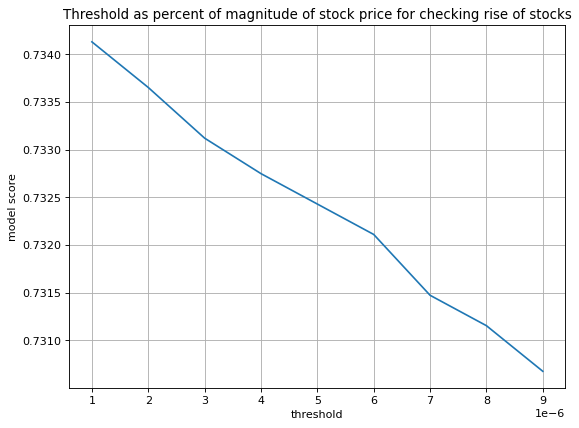

In [102]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='threshold', ylabel='model score')
plt.title("Threshold as percent of magnitude of stock price for checking rise of stocks")
plt.grid()

plt.plot(thresholds,np.sum(comp_thr, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

#### Testing min

In [140]:
test_min_max = 'min'
thresholds=np.arange(1e-6,1e-5, 1e-6) #We define epsilons as percent of order of magnitude 
comp_thr=np.zeros((len(list_of_companies_number), len(thresholds)))
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for threshold in range(thresholds.size):
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, thresholds[threshold], True, test_min_max)
        comp_thr[comp_id,threshold]=score

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
Number of positive class in training dataset = 108
Number of negative class in training dataset = 652
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 108
Number of nega

29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   0]
 [ 28   0]]
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   0]
 [ 28   0]]
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   0]
 [ 28   0]]
Number of positive class in training datase

Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of posit

Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Number of positive class in training dataset = 567
Number of negative class in training dataset = 193
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Number of positive class in training dataset = 568
Number of negative class in training dataset = 192
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
10
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333

25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[161   0]
 [ 29   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct cl

23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
Number of positive class in training dataset = 140
Number of negative class in training dataset = 620
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 140
Number of negative class in training dataset = 620
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 140
Number of negative class in training dataset = 620
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training

Number of positive class in training dataset = 178
Number of negative class in training dataset = 582
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 178
Number of negative class in training dataset = 582
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 178
Number of negative class in training dataset = 582
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 177
Number of negative class in training dataset = 583
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of posit

Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 141
Number of negative class in training dataset = 619
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of posit

18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
Number of positive class in training dataset = 149
Number of negative class in training dataset = 611
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[145   0]
 [ 45   0]]
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8210526315789474
Con

25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   0]
 [ 32   0]]
Number of positive class in training dataset = 131
Number of nega

Number of positive class in training dataset = 172
Number of negative class in training dataset = 588
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[148   0]
 [ 42   0]]
Number of positive class in training dataset = 170
Number of negative class in training dataset = 590
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Number of positive class in training dataset = 170
Number of negative class in training dataset = 590
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[149   0]
 [ 41   0]]
Number of posit

20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
Number of positive class in training dataset = 145
Number of negative class in training dataset = 615
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[141   0]
 [ 49   0]]
Number of positive class in

26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[142   0]
 [ 47   1]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[142   0]
 [ 47   1]]
Number of positive class in training dataset = 135
Number of negative class in training dataset = 625
Percent of correct classification:
0.7526

32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[157   0]
 [ 33   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[157   0]
 [ 33   0]]
Number of positive class in training dataset = 131
Number of negative class in training dataset = 629
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[157   0]
 [ 33   0]]
Number of positive class in training dataset = 131
Number of negati

Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 126
Number of negative class in training dataset = 634
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of positive class in training dataset = 126
Number of negative class in training dataset = 634
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[150   0]
 [ 40   0]]
Number of posit

Number of positive class in training dataset = 137
Number of negative class in training dataset = 623
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 137
Number of negative class in training dataset = 623
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 137
Number of negative class in training dataset = 623
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
49
19.322916666

25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
Number of positive class in training dataset = 133
Number of negative class in training dataset = 627
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[151   0]
 [ 39   0]]
Number of positive class in training dataset = 133
Number of negati

22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
Number of positive class in training dataset = 149
Number of negative class in training dataset = 611
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[158   1]
 [ 31   0]]
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Number of positive class in training dataset = 563
Number of negative class in training dataset = 197
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Number of positive class in training data

Number of positive class in training dataset = 133
Number of negative class in training dataset = 627
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[144   0]
 [ 46   0]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class in training dataset = 214
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 546
Number of negative class

Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
62
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were 

Number of positive class in training dataset = 157
Number of negative class in training dataset = 603
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[155   0]
 [ 35   0]]
65
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
Number of positive class in training dataset = 131
Number of negativ

22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
Number of positive class in training dataset = 136
Number of negative class in training dataset = 624
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training dataset = 136
Number of negati

25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
Number of positive class in training dataset = 129
Number of negative class in training dataset = 631
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training dataset = 128
Number of negative class in training dataset = 632
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training dataset = 127
Number of negative class in training dataset = 633
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[154   0]
 [ 36   0]]
Number of positive class in training datase

Number of positive class in training dataset = 139
Number of negative class in training dataset = 621
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[140   0]
 [ 50   0]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class in training dataset = 177
Percent of correct classification:
0.8
Confusion matrix:
[[  0  38]
 [  0 152]]
Number of positive class in training dataset = 583
Number of negative class

Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
Number of positive class in training dataset = 176
Number of negative class in training dataset = 584
Percent of correct classification:
0.8
Confusion matrix:
[[152   0]
 [ 38   0]]
78
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
2

14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[162   1]
 [ 27   0]]
Number of positive class in training dataset = 171
Number of negative class in training dataset = 589
Perce

32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
Number of positive class in training dataset = 139
Number of negative class in training dataset = 621
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[139   0]
 [ 51   0]]
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Number of positive class in training dataset = 571
Number of negative class in training dataset = 189
Percent of correct classification:
0.7842

39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset = 114
Number of negative class in training dataset = 646
Percent of correct classification:
0.868421052631579
Confusion matrix:
[[165   0]
 [ 25   0]]
Number of positive class in training dataset =

Number of positive class in training dataset = 152
Number of negative class in training dataset = 608
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[140   0]
 [ 49   1]]
Number of positive class in training dataset = 596
Number of negative class in training dataset = 164
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of positive class in training dataset = 597
Number of negative class in training dataset = 163
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Number of posit

Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
Number of positive class in training dataset = 132
Number of negative class in training dataset = 628
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[159   0]
 [ 31   0]]
94
21.197916666

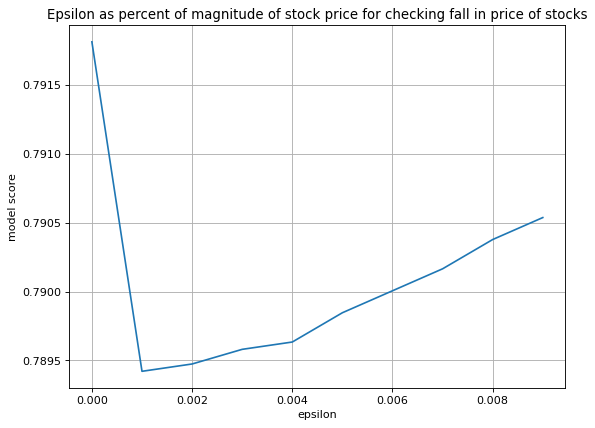

In [141]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.title("Epsilon as percent of magnitude of stock price for checking fall in price of stocks")
plt.grid()

plt.plot(epsilons,np.sum(comp_eps, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

### Find best (interesting in research life) threshold

In [140]:
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 60
test_min_max = 'max'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds = np.geomspace(1e-3, 1e-9, num = 7)
print(thresholds)
comp_thr=np.zeros((len(list_of_companies_number), len(thresholds)))

[1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]


In [141]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for threshold in range(thresholds.size):
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        score, precision, recall = test_logistic_regr_classic(X, np.copy(y),split_percent, thresholds[threshold], True, test_min_max)
        comp_thr[comp_id,threshold]=score
    

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4124207772315083
a   -0.003788055210746208
x   -0.20912684603855647
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 417
Number of negative class in training dataset = 343
Percen

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7626895919918097
a   -0.8294527302156394
x   -0.07572033549793913
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 664
Number of negative class in training dataset = 96
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6560314171260325
a   -0.6748671019915979
x   -0.07365963755985637
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 667
Number of negative class in training dataset = 93
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6560314171260325
a   -0.6748671019915979
x   -0.07365963755985637
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 667
Number of negative class in training dataset = 93
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6560314171260325
a   -0.6748671019915979
x   -0.07365963755985637
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 667
Number of negative class in training dataset = 93
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6560314171260325
a   -0.6748671019915979
x   -0.07365963755985637
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 667
Number of negative class in training dataset = 93
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.39182361752261324
a   -0.6104143792126238
x   0.6170692439932602
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 476
Number of negative class in training dataset = 284
Percent of correct classification:
0.6052631578947368
Confusion matrix:
[[  0  74]
 [  1 115]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4042603412822057
a   -0.6364634909356713
x   0.49897685366281663
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
2
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
24.53125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7191113527517088
a   -0.4848779659730135
x   1.2202612406779378
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 411
Number of negative class in training dataset = 349
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[23 52]
 [22 93]]
Precision:
0.30666666666666664
Recall:
0.5111111111111111
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.09375% of intervals were SELL empty
23.4375% of intervals were BUY empty
21.770833333333332% of intervals w

30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.015474841649266506
a   -1.1021215345680275
x   0.36896509975840086
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 611
Number of negative class in training dataset = 149
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  29]
 [  1 160]]
Precision:
0.0
Recall:
0.0
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2955261035606394
a   -0.9451523261558548
x   0.029243054838221608
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 643
Number of negative class in training dataset = 117
Percent of correct classification:
0.9
Confusion matrix:
[[  0  19]
 [  0 171]]
Precision:
0.0
Recall:
nan
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.386493274288716
a   -0.9152996707122868
x   0.007686267206017401
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 644
Number of negative class in training dataset = 116
Percent of correct classification:
0.9
Confusion matrix:
[[  0  19]
 [  0 171]]
Precision:
0.0
Recall:
nan
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY e

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.386493274288716
a   -0.9152996707122868
x   0.007686267206017401
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 644
Number of negative class in training dataset = 116
Percent of correct classification:
0.9
Confusion matrix:
[[  0  19]
 [  0 171]]
Precision:
0.0
Recall:
nan
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.386493274288716
a   -0.9152996707122868
x   0.007686267206017401
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 644
Number of negative class in training dataset = 116
Percent of correct classification:
0.9
Confusion matrix:
[[  0  19]
 [  0 171]]
Precision:
0.0
Recall:
nan
4
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price



m   1.3492807490613004
a   0.2234137764517855
x   0.3573578412418644
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 411
Number of negative class in training dataset = 349
Percent of correct classification:
0.49473684210526314
Confusion matrix:
[[74 27]
 [69 20]]
Precision:
0.7326732673267327
Recall:
0.5174825174825175
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of interv

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


Coefficient impact:
m   0.8597481860340676
a   -0.09231830291613839
x   0.30124671923998847
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 579
Number of negative class in training dataset = 181
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Precision:
0.0
Recall:
nan
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals w

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.6898316684593657
a   0.10699858887284308
x   0.3871048873751571
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 608
Number of negative class in training dataset = 152
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.6041

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.7172203103400755
a   0.12516688075988416
x   0.44246680075950756
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 610
Number of negative class in training dataset = 150
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.7172203103400755
a   0.12516688075988416
x   0.44246680075950756
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 610
Number of negative class in training dataset = 150
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


   0.7172203103400755
a   0.12516688075988416
x   0.44246680075950756
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 610
Number of negative class in training dataset = 150
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
21.302083333333332% of intervals were SELL empty
24.635416666666668% of intervals were BUY empty
22.604166666666668% of intervals were SELL empty
26.5625% of intervals were BUY empty
22.60416

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.7172203103400755
a   0.12516688075988416
x   0.44246680075950756
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 610
Number of negative class in training dataset = 150
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
5
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336%

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1062493326821063
a   -0.590015436877935
x   0.9186146593153257
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1062493326821063
a   -0.590015436877935
x   0.9186146593153257
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1062493326821063
a   -0.590015436877935
x   0.9186146593153257
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[  0  34]
 [  0 156]]
Precision:
0.0
Recall:
nan
20.677083333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1062493326821063
a   -0.590015436877935
x   0.9186146593153257
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[  0  34]
 [  0 156]]
Precision:
0.0
Recall:
nan
20.677083333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
20.677083333333332% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
29.114583333333332% of intervals were SELL empty
34.270833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1062493326821063
a   -0.590015436877935
x   0.9186146593153257
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7234441392678909
a   -0.7261699419855617
x   0.508157734222091
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 472
Number of negative class in training dataset = 288
Percent of correct classification:
0.5631578947368421
Confusion matrix:
[[  0  78]
 [  5 107]]
Precision:
0.0
Recall:
0.0
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06602476164190649
a   -0.5822691171118974
x   -0.0678128404049481
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06602476164190649
a   -0.5822691171118974
x   -0.0678128404049481
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06602476164190649
a   -0.5822691171118974
x   -0.0678128404049481
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06602476164190649
a   -0.5822691171118974
x   -0.0678128404049481
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
24.479166666666668% of intervals were SELL empty
26.145833333333332% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.9375% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06602476164190649
a   -0.5822691171118974
x   -0.0678128404049481
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5860828526949037
a   0.6828460943029129
x   0.3119608028678342
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 380
Number of negative class in training dataset = 380
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5112341535652306
a   0.18478603005427863
x   0.09384975487675372
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 636
Number of negative class in training dataset = 124
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
21.458333333333332% of intervals were SELL empty
20.3125% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.52808658120052
a   0.13963534366518768
x   0.014482383153339553
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
21.458333333333332% of intervals were SELL empty
20.3125% of inter

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.52808658120052
a   0.13963534366518768
x   0.014482383153339553
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
21.458333333333332% of intervals were SELL empty
20.3125% of inter

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.52808658120052
a   0.13963534366518768
x   0.014482383153339553
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
21.458333333333332% of intervals were SELL empty
20.3125% of inter

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
21.458333333333332% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.52808658120052
a   0.13963534366518768
x   0.014482383153339553
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
8
21.354166666666668% of intervals were SELL empty
24.427083333333

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.15482644680555668
a   0.25769533884945306
x   0.29887266989279154
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 452
Number of negative class in training dataset = 308
Percent of correct classification:
0.5263157894736842
Confusion matrix:
[[34 57]
 [33 66]]
Precision:
0.37362637362637363
Recall:
0.5074626865671642
21.354166666666668% of intervals were SELL empty
24.427083333333

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2232795548272763
a   0.1854330989334014
x   -0.4552914416029393
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2547408624568281
a   0.1363556356940336
x   -0.4217510129946991
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2547408624568281
a   0.1363556356940336
x   -0.4217510129946991
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2547408624568281
a   0.1363556356940336
x   -0.4217510129946991
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2547408624568281
a   0.1363556356940336
x   -0.4217510129946991
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
9
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.17488027453548663
a   -0.0823200110531678
x   1.0864763570551503
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 404
Number of negative class in training dataset = 356
Percent of correct classification:
0.5526315789473685
Confusion matrix:
[[29 58]
 [27 76]]
Precision:
0.3333333333333333
Recall:
0.5178571428571429
25.364583333333332% of intervals were SELL empty
16.614583

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.17088332165514594
a   -0.5933703929609379
x   0.2631824646283636
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14346796766333278
a   -0.60088515563213
x   0.23803659559380594
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 652
Number of negative class in training dataset = 108
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14346796766333278
a   -0.60088515563213
x   0.23803659559380594
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 652
Number of negative class in training dataset = 108
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14346796766333278
a   -0.60088515563213
x   0.23803659559380594
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 652
Number of negative class in training dataset = 108
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0
Recall:
nan
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals wer

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
25.364583333333332% of intervals were SELL empty
16.614583333333332% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
27.916666666666668% of intervals were SELL empty
20.78125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14346796766333278
a   -0.60088515563213
x   0.23803659559380594
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 652
Number of negative class in training dataset = 108
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0
Recall:
nan
10
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.70971886779787
a   -0.8240368963003202
x   0.40795705473345845
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 359
Number of negative class in training dataset = 401
Percent of correct classification:
0.5368421052631579
Confusion matrix:
[[68 36]
 [52 34]]
Precision:
0.6538461538461539
Recall:
0.5666666666666667
13.802083333333334%

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.21476914142634287
a   -0.5219125511375078
x   0.1118213537925229
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
Precision:
0.0
Recall:
nan
13.802083333333334% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3398376458173469
a   -0.5755936057565016
x   0.10187614172039051
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 603
Number of negative class in training dataset = 157
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
Precision:
0.0
Recall:
nan
13.802083333333334% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3398376458173469
a   -0.5755936057565016
x   0.10187614172039051
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 603
Number of negative class in training dataset = 157
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
Precision:
0.0
Recall:
nan
13.802083333333334% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3398376458173469
a   -0.5755936057565016
x   0.10187614172039051
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 603
Number of negative class in training dataset = 157
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
Precision:
0.0
Recall:
nan
13.802083333333334% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
13.802083333333334% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
15.520833333333334% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3398376458173469
a   -0.5755936057565016
x   0.10187614172039051
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 603
Number of negative class in training dataset = 157
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
Precision:
0.0
Recall:
nan
11
23.75% of intervals were SELL empty
20.3

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29707271606149616
a   -1.7002565468508897
x   0.8542389882734138
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 498
Number of negative class in training dataset = 262
Percent of correct classification:
0.5526315789473685
Confusion matrix:
[[  3  83]
 [  2 102]]
Precision:
0.03488372093023256
Recall:
0.6
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10761888569303556
a   -1.0180763883627166
x   0.3668142166724176
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of interval

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10761888569303556
a   -1.0180763883627166
x   0.3668142166724176
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of interval

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10761888569303556
a   -1.0180763883627166
x   0.3668142166724176
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of interval

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10761888569303556
a   -1.0180763883627166
x   0.3668142166724176
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.10761888569303556
a   -1.0180763883627166
x   0.3668142166724176
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
12
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% o

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3098293166952987
a   -0.02044548290134266
x   -0.38916758554122916
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 389
Number of negative class in training dataset = 371
Percent of correct classification:
0.5157894736842106
Confusion matrix:
[[74 17]
 [75 24]]
Precision:
0.8131868131868132
Recall:
0.4966442953020134
24.21875% of intervals were SELL empty
20.15625% of inte

26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5905966931785844
a   0.19866517410561704
x   0.14223924509901087
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 605
Number of negative class in training dataset = 155
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6255387097227718
a   0.2257069208618042
x   0.07653502171792242
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 637
Number of negative class in training dataset = 123
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[  0  28]
 [  0 162]]
Precision:
0.0
Recall:
nan
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6255387097227718
a   0.2257069208618042
x   0.07653502171792242
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 637
Number of negative class in training dataset = 123
Percent of correct classification:
0.8578947368421053
Confusion matrix:
[[  0  27]
 [  0 163]]
Precision:
0.0
Recall:
nan
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6443374641011341
a   0.33383653205902475
x   0.0592575240098407
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 638
Number of negative class in training dataset = 122
Percent of correct classification:
0.8578947368421053
Confusion matrix:
[[  0  27]
 [  0 163]]
Precision:
0.0
Recall:
nan
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6443374641011341
a   0.33383653205902475
x   0.0592575240098407
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 638
Number of negative class in training dataset = 122
Percent of correct classification:
0.8578947368421053
Confusion matrix:
[[  0  27]
 [  0 163]]
Precision:
0.0
Recall:
nan
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
25.677083333333332% of intervals were SELL empty
18.229166666666668% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
26.25% of intervals were SELL empty
18.4375% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6443374641011341
a   0.33383653205902475
x   0.0592575240098407
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 638
Number of negative class in training dataset = 122
Percent of correct classification:
0.8578947368421053
Confusion matrix:
[[  0  27]
 [  0 163]]
Precision:
0.0
Recall:
nan
14
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.21233145955866664
a   0.20893530644873737
x   0.5595309445590909
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 398
Number of negative class in training dataset = 362
Percent of correct classification:
0.4263157894736842
Confusion matrix:
[[32 48]
 [61 49]]
Precision:
0.4
Recall:
0.34408602150537637
17.760416666666668% of intervals were SELL empty
28.4

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.30686655845305166
a   -0.08808612692194419
x   0.5416087390936637
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 573
Number of negative class in training dataset = 187
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
17.760416666666668% of intervals were SELL empty
28.4375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28295143734442957
a   -0.1241147355953123
x   0.5205823996401397
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 574
Number of negative class in training dataset = 186
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
17.760416666666668% of intervals were SELL empty
28.4375% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.27576086230103264
a   -0.17789498232602735
x   0.4674591916795075
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 575
Number of negative class in training dataset = 185
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
17.760416666666668% of intervals were SELL empty
28.4375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.27576086230103264
a   -0.17789498232602735
x   0.4674591916795075
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 575
Number of negative class in training dataset = 185
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
17.760416666666668% of intervals were SELL empty
28.4375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
17.760416666666668% of intervals were SELL empty
28.4375% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
30.364583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.27576086230103264
a   -0.17789498232602735
x   0.4674591916795075
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 575
Number of negative class in training dataset = 185
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Preci

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5293957290556094
a   -0.31290319416872264
x   1.419212558444127
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 394
Number of negative class in training dataset = 366
Percent of correct classification:
0.5368421052631579
Confusion matrix:
[[44 50]
 [38 58]]
Precision:
0.46808510638297873
Recall:
0.5365853658536586
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
2

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31251290764312384
a   -0.5213291554880882
x   0.8757317663251555
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 614
Number of negative class in training dataset = 146
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.32393002553235606
a   -0.5120343296698162
x   0.8387733470000035
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.32393002553235606
a   -0.5120343296698162
x   0.8387733470000035
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.32393002553235606
a   -0.5120343296698162
x   0.8387733470000035
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
20.78125% of intervals were SELL empty
27.03125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.32393002553235606
a   -0.5120343296698162
x   0.8387733470000035
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
16
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of i

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.20698154542834657
a   -0.14626135233032325
x   0.13141662101305712
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 496
Number of negative class in training dataset = 264
Percent of correct classification:
0.5473684210526316
Confusion matrix:
[[  3  86]
 [  0 101]]
Precision:
0.033707865168539325
Recall:
1.0
23.020833333333332% of in

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7275112498064658
a   -0.37378204428813433
x   -0.4307644451677523
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 632
Number of negative class in training dataset = 128
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[  0  34]
 [  0 156]]
Precision:
0.0
Recall:
nan
23.020833333333332% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7714871197585821
a   -0.4063137052464117
x   -0.4011835657111182
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[  0  34]
 [  0 156]]
Precision:
0.0
Recall:
nan
23.020833333333332% of intervals were SELL e

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7714871197585821
a   -0.4063137052464117
x   -0.4011835657111182
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[  0  34]
 [  0 156]]
Precision:
0.0
Recall:
nan
23.020833333333332% of intervals were SELL e

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7714871197585821
a   -0.4063137052464117
x   -0.4011835657111182
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of correct classification:
0.8210526315789474
Confusion matri

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
24.270833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7714871197585821
a   -0.4063137052464117
x   -0.4011835657111182
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative clas

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.43149970756821654
a   -0.8575411775006947
x   0.5518430028712428
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 483
Number of negative class in training dataset = 277
Percent of correct classification:
0.5473684210526316
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5440570190305145
a   -0.7435289448882629
x   0.38034187624406074
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 636
Number of negative cla

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.45740597203586153
a   -0.6894684209349581
x   0.2458555612044214
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8315789473684211
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.45740597203586153
a   -0.6894684209349581
x   0.2458555612044214
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8315789473684211
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.45740597203586153
a   -0.6894684209349581
x   0.2458555612044214
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8315789473684211
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
22.135416666666668% of intervals were SELL empty
21.614583333333332% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
23.958333333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.45740597203586153
a   -0.6894684209349581
x   0.2458555612044214
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8315789473684211
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.36902341445792824
a   0.4004315159548772
x   1.249281573358591
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 377
Number of negative class in training dataset = 383
Percent of correct classification:
0.5368421052631579
Confusion matrix:
[[88 38]
 [50 14]]
Precision:
0.6984126984126984
Recall:
0.6376811594202898
18.177083333333332% of intervals were SELL emp

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3342071375458462
a   -0.5024196091735772
x   0.44632010442944886
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 596
Number of negative class in training dataset = 164
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
18.177083333333332% of intervals were SELL empty
23.75% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29919384098966234
a   -0.4818039581585963
x   0.42867909626889444
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
18.177083333333332% of intervals 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29919384098966234
a   -0.4818039581585963
x   0.42867909626889444
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29919384098966234
a   -0.4818039581585963
x   0.42867909626889444
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.177083333333332% of intervals were SELL empty
23.75% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
18.802083333333332% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29919384098966234
a   -0.4818039581585963
x   0.42867909626889444
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 598
Number of negative class in training dataset = 162
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
19
19.375% of intervals were SELL empty
27.708333333333332% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
22.5% of intervals were SELL empty
29.635416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3323023640478394
a   -1.0301391802019748
x   1.0502479360680472
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 408
Number of negative class in training dataset = 352
Percent of correct classification:
0.5473684210526316
Confusion matrix:
[[42 54]
 [32 62]]
Precision:
0.4375
Recall:
0.5675675675675675
19.375% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
19.375% of intervals were

24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3528762346837753
a   -1.022295069606039
x   1.1008622820417613
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 601
Number of negative class in training dataset = 159
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.46059533439894457
a   -0.8348347018648657
x   1.0125693272258482
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of correct classification:
0.8263157894736842
Confusion matrix:
[[  0  33]
 [  0 157]]
Precision:
0.0
Recall:
nan
23.75% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4668254718095473
a   -0.9065321648972952
x   1.0346713339077234
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of interva

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4668254718095473
a   -0.9065321648972952
x   1.0346713339077234
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of interva

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4668254718095473
a   -0.9065321648972952
x   1.0346713339077234
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of interva

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
23.75% of intervals were SELL empty
23.28125% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
24.010416666666668% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4668254718095473
a   -0.9065321648972952
x   1.0346713339077234
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
21
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.9519601245371592
a   -0.23843408920169232
x   1.1175051800090505
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 480
Number of negative class in training dataset = 280
Percent of correct classification:
0.48947368421052634
Confusion matrix:
[[14 88]
 [ 9 79]]
Precision:
0.13725490196078433
Recall:
0.6086956521739

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4207563559365427
a   -0.31331221326194203
x   0.8754027603718102
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
18.59375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4291198378267029
a   -0.31849779316994337
x   0.8194201376840572
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
18.59375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.44315617473406393
a   -0.3259010035544068
x   0.8311229011955313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 629
Number of negative class in training dataset = 131
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
18.59375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.44315617473406393
a   -0.3259010035544068
x   0.8311229011955313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 629
Number of negative class in training dataset = 131
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
18.59375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
18.59375% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
24.375% of intervals were SELL empty
36.354166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.44315617473406393
a   -0.3259010035544068
x   0.8311229011955313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 629
Number of negative class in training dataset = 131
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
22
24.739583333333332% o

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28834494753177553
a   -0.4589001827840202
x   0.4639175014596603
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 415
Number of negative class in training dataset = 345
Percent of correct classification:
0.5210526315789473
Confusion matrix:
[[ 3 81]
 [10 96]]
Precision:
0.03571428571428571
Re

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.0064152715294123535
a   -0.2015932266636275
x   -0.006256786970134521
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 631
Number of negative class in training dataset = 129
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
n

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.043384977191070755
a   -0.21911351268354767
x   -0.027327029564131685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 632
Number of negative class in training dataset = 128
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
n

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.043384977191070755
a   -0.21911351268354767
x   -0.027327029564131685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 632
Number of negative class in training dataset = 128
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
n

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.043384977191070755
a   -0.21911351268354767
x   -0.027327029564131685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 632
Number of negative class in training dataset = 128
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
n

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
24.739583333333332% of intervals were SELL empty
16.197916666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.043384977191070755
a   -0.21911351268354767
x   -0.027327029564131685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 632
Number of negative class in training dataset = 128
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
n

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6765096360367736
a   0.1577739897977831
x   0.27117469893723817
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 448
Number of negative class in training dataset = 312
Percent of correct classification:
0.6421052631578947
Confusion matrix:
[[  1  67]
 [  1 121]]
Precision:
0.014705882352941176
Recall:
0.5
24.322916666666668% of inte

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.36660733733164497
a   0.03132039014550108
x   0.13688438117435608
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8894736842105263
Confusion matrix:
[[  0  21]
 [  0 169]]
Precision:
0.0
Recall:
nan
24.322916666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.36660733733164497
a   0.03132039014550108
x   0.13688438117435608
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8894736842105263
Confusion matrix:
[[  0  21]
 [  0 169]]
Precision:
0.0
Recall:
nan
24.322916666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.36660733733164497
a   0.03132039014550108
x   0.13688438117435608
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8894736842105263
Confusion matrix:
[[  0  21]
 [  0 169]]
Precision:
0.0
Recall:
nan
24.322916666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.36660733733164497
a   0.03132039014550108
x   0.13688438117435608
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8894736842105263
Confusion matrix:
[[  0  21]
 [  0 169]]
Precision:
0.0
Recall:
nan
24.322916666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.36660733733164497
a   0.03132039014550108
x   0.13688438117435608
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8894736842105263
Confusion matrix:
[[  0  21]
 [  0 169]]
Precision:
0.0
Recall:
nan
24
25.104166666666668% of intervals were S

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.046287504665662504
a   -0.5693777809506122
x   1.3532208317927534
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 448
Number of negative class in training dataset = 312
Percent of correct classification:
0.4368421052631579
Confusion matrix:
[[  2 103]
 [  4  81]]
Precision:
0.01904761904761905
Recall:
0.3333333333333333
25.10416666

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.011038414573327708
a   -0.46232376775682704
x   0.7333611745177101
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
25.104166666666668% of intervals were SEL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.0025157726308052387
a   -0.5093552587760848
x   0.7914971031542591
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
25.104166666666668% of intervals were SEL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.07292958312394567
a   -0.5132458455451583
x   0.8246193651855988
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
25.104166666666668% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.07292958312394567
a   -0.5132458455451583
x   0.8246193651855988
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
25.104166666666668% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.07292958312394567
a   -0.5132458455451583
x   0.8246193651855988
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
25
24.6875% of intervals were SELL empty
18

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.39923651094097684
a   -0.16046571881324653
x   -0.9124775884996952
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 478
Number of negative class in training dataset = 282
Percent of correct classification:
0.3105263157894737
Confusion matrix:
[[  2 116]
 [ 15  57]]
Precision:
0.01694915254237288
Recall:
0.11764705882352941
24.6875% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.15500222096673322
a   -0.23118754782953313
x   -0.42386192377016757
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.15500222096673322
a   -0.23118754782953313
x   -0.42386192377016757
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.15500222096673322
a   -0.23118754782953313
x   -0.42386192377016757
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.15500222096673322
a   -0.23118754782953313
x   -0.42386192377016757
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
Precision:
0.0
Recall:
nan
24.6875% of intervals were SELL empty
18.4375% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.6875% of intervals were SELL empty
18.4375% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
36.25% of intervals were SELL empty
28.802083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.15500222096673322
a   -0.23118754782953313
x   -0.42386192377016757
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
Precision:
0.0
Recall:
nan
26
18.072916666666668% of intervals were SELL empty
31.5625% 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6012545259875463
a   0.5518275276720996
x   0.8726415616973188
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 459
Number of negative class in training dataset = 301
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[  2  72]
 [  2 114]]
Precision:
0.02702702702702703
Recall:
0.5
18.072916666666668% of intervals were SELL empty
31.56

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.39664160501572415
a   0.618775849959227
x   1.0624329676662827
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2939858384581931
a   0.5763458179156159
x   1.0339602397783332
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2939858384581931
a   0.5763458179156159
x   1.0339602397783332
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2939858384581931
a   0.5763458179156159
x   1.0339602397783332
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
18.072916666666668% of intervals were SELL empty
31.5625% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
20.3125% of intervals were SELL empty
32.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2939858384581931
a   0.5763458179156159
x   1.0339602397783332
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
27
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.02952327845310434
a   -0.33749882238141016
x   0.23788539306456566
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 542
Number of negative class in training dataset = 218
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[  0  55]
 [  3 132]]
Precision:
0.0
Recall:
0.0
29.375% of intervals were SELL empty
14.739583333333334% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.23935848782989805
a   -0.7198958591549703
x   0.501296531620887
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 659
Number of negative class in training dataset = 101
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2629020239577389
a   -0.6860206628283659
x   0.4836030842217846
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2629020239577389
a   -0.6860206628283659
x   0.4836030842217846
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2629020239577389
a   -0.6860206628283659
x   0.4836030842217846
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
29.375% of intervals were SELL empty
14.739583333333334% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.197916666666668% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2629020239577389
a   -0.6860206628283659
x   0.4836030842217846
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correct classification:
0.8473684210526315
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
23.333333333333332% of intervals were SELL empty
20.364583333333332% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
25.0% of intervals were SELL empty
25.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8744821120476095
a   -0.6120247127384083
x   0.49400675419452156
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 354
Number of negative class in training dataset = 406
Percent of correct classification:
0.531578947368421
Confusion matrix:
[[79 35]
 [54 22]]
Precision:
0.6929824561403509
Recall:
0.5939849624060151
23.33333333333333

25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14911830939438914
a   -0.4929334139006111
x   0.4488820311981762
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 650
Number of negative class in training dataset = 110
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
25.416666666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2677008977159629
a   -0.47735345000780277
x   0.8564503190301869
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 657
Number of negative class in training dataset = 103
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
25.416666666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2677008977159629
a   -0.47735345000780277
x   0.8564503190301869
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 657
Number of negative class in training dataset = 103
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
25.416666666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2677008977159629
a   -0.47735345000780277
x   0.8564503190301869
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 657
Number of negative class in training dataset = 103
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
25.416666666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2677008977159629
a   -0.47735345000780277
x   0.8564503190301869
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 657
Number of negative class in training dataset = 103
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
25.416666666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
19.375% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
30.78125% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2677008977159629
a   -0.47735345000780277
x   0.8564503190301869
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 657
Number of negative class in training dataset = 103
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
30
19.53125% of interva

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.9862207310571467
a   -0.5569252014636592
x   1.0235162857773945
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 361
Number of negative class in training dataset = 399
Percent of correct classification:
0.48947368421052634
Confusion matrix:
[[14 88]
 [ 9 79]]
Precision:
0.13725490196078433
Recall:
0.6086956521739131
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SE

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7031893908123256
a   -1.9426627355843487
x   1.1291750941707999
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of interva

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5848946454649252
a   -2.04549832895217
x   1.2182737258555347
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5848946454649252
a   -2.04549832895217
x   1.2182737258555347
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5848946454649252
a   -2.04549832895217
x   1.2182737258555347
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
19.53125% of intervals were SELL empty
24.6875% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.5848946454649252
a   -2.04549832895217
x   1.2182737258555347
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
31
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5315157764792205
a   -0.9365496204070204
x   0.7526805795366253
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 429
Number of negative class in training dataset = 331
Percent of correct classification:
0.531578947368421
Confusion matrix:
[[51 66]
 [23 50]]
Precision:
0.4358974358974359
Recall:
0.6891891891891891


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.03353785416452212
a   -0.4073683842909926
x   0.41315904521539193
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
20.885416666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.03187862384593538
a   -0.3914076969368193
x   0.42847496838909316
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
20.885416666666668% of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.035499393487625236
a   -0.42669548729404266
x   0.4581125208431043
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
20.885416666666668% o

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.035499393487625236
a   -0.42669548729404266
x   0.4581125208431043
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
20.885416666666668% o

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
20.885416666666668% of intervals were SELL empty
22.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
27.135416666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.035499393487625236
a   -0.42669548729404266
x   0.4581125208431043
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
32
17.447916666666668

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
17.916666666666668% of intervals were SELL empty
32.447916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4196971490199431
a   1.074770648632818
x   0.3538294199172587
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 366
Number of negative class in training dataset = 394
Percent of correct classification:
0.5631578947368421
Confusion matrix:
[[65  7]
 [76 42]]
Precision:
0.9027777777777778
Recall:
0.46099290780141844
17.447916666666668% of intervals were SELL empty
32.239583333333336% of intervals were BUY empty
17.447916666666668%

(950,)
Coefficient impact:
m   0.20538672623843726
a   0.7499710272273992
x   0.050183391868999346
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 374
Number of negative class in training dataset = 386
Percent of correct classification:
0.5368421052631579
Confusion matrix:
[[74 31]
 [57 28]]
Precision:
0.7047619047619048
Recall:
0.5648854961832062
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.06472897245713502
a   0.09478102859441359
x   0.402966929069242
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 599
Number of negative class in training dataset = 161
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.09905398380127263
a   0.05880124565175112
x   0.4401893752782607
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 601
Number of negative class in training dataset = 159
Percent of correct classifi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.09905398380127263
a   0.05880124565175112
x   0.4401893752782607
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 601
Number of negative class in training dataset = 159
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.09905398380127263
a   0.05880124565175112
x   0.4401893752782607
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 601
Number of negative class in training dataset = 159
Percent of correct classifi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
16.614583333333332% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
18.645833333333332% of intervals were SELL empty
25.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.09905398380127263
a   0.05880124565175112
x   0.4401893752782607
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 601
Number of negative class in training dataset = 159
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0
Recall:
nan
34

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4928338538595182
a   0.7944764856197387
x   -0.7800572768239467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 409
Number of negative class in training dataset = 351
Percent of correct classification:
0.5736842105263158
Confusion matrix:
[[21 54]
 [27 88]]
Precision:
0.28
Recall:
0.4375
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7161922593092026
a   -0.0995981993088065
x   -0.9653729046089428
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7550965462247615
a   -0.14311687990625255
x   -0.9929124422143534
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7550965462247615
a   -0.14311687990625255
x   -0.9929124422143534
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7550965462247615
a   -0.14311687990625255
x   -0.9929124422143534
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7550965462247615
a   -0.14311687990625255
x   -0.9929124422143534
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan
35
17.1875% of intervals were SELL empty
24.791666666666668% of in

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.008557485635471977
a   -0.6902927745753026
x   1.2271364762953358
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 348
Number of negative class in training dataset = 412
Percent of correct classification:
0.5263157894736842
Confusion matrix:
[[90  7]
 [83 10]]
Precision:
0.9278350515463918
Recall:
0.5202312138728

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.29866587778469067
a   -0.050098376116823974
x   0.8910673114922188
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 591
Number of negative class in training dataset = 169
Percent of correct classification:
0.7736842105263158
Conf

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31023455830135904
a   -0.07233496264548307
x   0.8550057150403267
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 595
Number of negative class in training dataset = 165
Percent of correct classification:
0.7736842105263158
Confu

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31023455830135904
a   -0.07233496264548307
x   0.8550057150403267
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 595
Number of negative class in training dataset = 165
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
17.1875% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31023455830135904
a   -0.07233496264548307
x   0.8550057150403267
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 595
Number of negative class in training dataset = 165
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
17.1875% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31023455830135904
a   -0.07233496264548307
x   0.8550057150403267
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 595
Number of negative class in training dataset = 165
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
36
20.208333333333332% 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3021452503042542
a   -0.5129005471545253
x   2.175193312878178
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 482
Number of negative class in training dataset = 278
Percent of correct classification:
0.5421052631578948
Confusion matrix:
[[  1  87]
 [  0 102]]
Precision:
0.011363636363636364
Recall:
1.0
20.208333333333332% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1423083686828565
a   -0.14073205277394163
x   1.2987030002793887
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 631
Number of negative class in training dataset = 129
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL e

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1310239715488063
a   -0.16846696127994085
x   1.295864910670472
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1310239715488063
a   -0.16846696127994085
x   1.295864910670472
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[  0  50]
 [  0 140]]
Precision:
0.0
Recall:
nan
20.208333333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1310239715488063
a   -0.16846696127994085
x   1.295864910670472
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.7368421052631579
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1310239715488063
a   -0.16846696127994085
x   1.295864910670472
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.7368421052631579
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5058847416371619
a   1.0221322140968672
x   0.18696285043376404
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 375
Number of negative class in training dataset = 385
Percent of correct classification:
0.4421052631578947
Confusion matrix:
[[76 24]
 [82  8]]
Precision:
0.76
Recall:
0.4810126582278481
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8024630416871424
a   0.18493661328572392
x   -0.08515048148583627
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8121136772815996
a   0.171882806131202
x   -0.08710693297106857
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
17.65625

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8121136772815996
a   0.171882806131202
x   -0.08710693297106857
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
17.65625% of intervals were SELL empty
29.84375% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
18.489583333333332% of intervals were SELL empty
30.104166666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8121136772815996
a   0.171882806131202
x   -0.08710693297106857
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
38
23.489583333333332% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
(950,)
Coefficient impact:

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   -0.6495492302623755
a   -0.8388059159556909
x   0.4603002327028753
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 453
Number of negative class in training dataset = 307
Percent of correct classification:
0.5789473684210527
Confusion matrix:
[[  0  80]
 [  0 110]]
Precision:
0.0
Recall:
nan
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% o

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   -0.1682806168042154
a   -0.8017590746351595
x   0.3345638138061275
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 612
Number of negative class in training dataset = 148
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% o

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


Coefficient impact:
m   0.08863678139142098
a   -0.710108010081164
x   0.1753892610522906
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.12847146740247575
a   -0.7736925845708562
x   0.18063751402070313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


Coefficient impact:
m   0.12847146740247575
a   -0.7736925845708562
x   0.18063751402070313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
2

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.12847146740247575
a   -0.7736925845708562
x   0.18063751402070313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.114583333333332% of intervals were SELL empty
23.072916666666668% 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.12847146740247575
a   -0.7736925845708562
x   0.18063751402070313
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
39
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.4583333333

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.16202886123965823
a   -0.7469880774740237
x   0.5519654313816809
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precisi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14574432220799768
a   -0.7714776072742882
x   0.5438735125636213
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of corre

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14574432220799768
a   -0.7714776072742882
x   0.5438735125636213
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Precisi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14574432220799768
a   -0.7714776072742882
x   0.5438735125636213
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Precisi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
26.458333333333332% of intervals were SELL empty
29.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.14574432220799768
a   -0.7714776072742882
x   0.5438735125636213
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Precisi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.31178187053227696
a   -0.6315905950893472
x   -0.07732856368658994
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 412
Number of negative class in training dataset = 348
Percent of correct classification:
0.5
Confusion matrix:


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.24300291901471138
a   0.2638927419286575
x   0.018894686114364085
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28684916130411975
a   0.27006724907977825
x   -0.04469103292171038
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 637
Number of negative class in training dataset = 123
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28684916130411975
a   0.27006724907977825
x   -0.04469103292171038
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 637
Number of negative class in training dataset = 123
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28684916130411975
a   0.27006724907977825
x   -0.04469103292171038
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 637
Number of negative class in training dataset = 123
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.020833333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
21.510416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.28684916130411975
a   0.27006724907977825
x   -0.04469103292171038
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 637
Number of negative class in training dataset = 123
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
41
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668%

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7089651363337881
a   -0.04420914789187231
x   -0.20520157377692866
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 454
Number of negative class in training dataset = 306
Percent of correct classification:
0.4789473684210526
Confusion matrix:
[[ 7 98]
 [ 1 84]]
Precision:
0.06666666666666667
Recall:
0.875
17.395833333333332% of intervals were SELL empty
28.385416666666668

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2926318999301008
a   -0.3431120667185372
x   0.5739171983368345
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.6842105263157895
Confusion matrix:
[[  0  60]
 [  0 130]]
Precision:
0.0

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2873752172496422
a   -0.37819824233561905
x   0.7367304049474761
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[  0  59]
 [  0 131]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3188907388693237
a   -0.38827959215600566
x   0.8114727654923747
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[  0  59]
 [  0 131]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3188907388693237
a   -0.38827959215600566
x   0.8114727654923747
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[  0  59]
 [  0 131]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
17.395833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
28.28125% of intervals were SELL empty
34.791666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3188907388693237
a   -0.38827959215600566
x   0.8114727654923747
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[  0  59]
 [  0 131]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4704365006594759
a   -0.29091962445156844
x   0.89224660107683
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 432
Number of negative class in training dataset = 328
Percent of correct classification:
0.531578947368421
Confusion matrix:
[[24 71]
 [18 77]]
Precision:
0.25263157894736843
Recall:
0.5714285714285714
32.8125% of intervals were SELL empty
18.125% of intervals were BU

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.02839233940813243
a   -0.5625361522916211
x   0.1914287269606825
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.022019247680938863
a   -0.5596082891535166
x   0.19941081895907717
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of in

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.022019247680938863
a   -0.5596082891535166
x   0.19941081895907717
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.022019247680938863
a   -0.5596082891535166
x   0.19941081895907717
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
32.8125% of intervals were SELL empty
18.125% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
33.333333333333336% of intervals were SELL empty
19.427083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.022019247680938863
a   -0.5596082891535166
x   0.19941081895907717
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
43
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
20.364583333333332% of intervals were SELL empty
22.760416666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.186324837413769
a   -0.44891938509889473
x   1.2753194748553485
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 358
Number of negative class in training dataset = 402
Percent of correct classification:
0.6263157894736842
Confusion matri

33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
(950,)


<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
m   0.5912620879844583
a   -0.19626166647132914
x   0.20446891635837106
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 476
Number of negative class in training dataset = 284
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[19 57]
 [21 93]]
Precision:
0.25
Recall:
0.475
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals w

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.5324378196318893
a   -0.12539847117437392
x   0.11354664395659883
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 596
Number of negative class in training dataset = 164
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[  0  54]
 [  0 136]]
Precision:
0.0
Recall:
nan
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.3806661804397927
a   0.20912492296060017
x   -0.07215989280347443
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 608
Number of negative class in training dataset = 152
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


Coefficient impact:
m   0.3806661804397927
a   0.20912492296060017
x   -0.07215989280347443
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 608
Number of negative class in training dataset = 152
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals 

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.36534516412549717
a   0.23112057774718955
x   -0.09115732769839202
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.36534516412549717
a   0.23112057774718955
x   -0.09115732769839202
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
27.708333333333332% of intervals were SELL empty
26.71875% of intervals were BUY empty
33.90625% of intervals were SELL empty
32.395833333333336% of intervals were BUY empty
33.90625% of intervals were SELL empty
32

<ipython-input-88-df184d4de3c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



m   0.36534516412549717
a   0.23112057774718955
x   -0.09115732769839202
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
45
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.050247038765960095
a   -1.4161444638470895
x   0.7419242875796925
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.050247038765960095
a   -1.4161444638470895
x   0.7419242875796925
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
19.479166666666668% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.050247038765960095
a   -1.4161444638470895
x   0.7419242875796925
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
19.479166666666668% of interv

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
19.479166666666668% of intervals were SELL empty
26.25% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.050247038765960095
a   -1.4161444638470895
x   0.7419242875796925
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recall:
nan
46
16.666666666666668% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3772573602101981
a   -0.9807802721830854
x   -0.07773457666986773
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 542
Number of negative class in training dataset = 218
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[  1  44]
 [  2 143]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.28935284907368564
a   -1.1312409331659525
x   0.06225355148683695
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.28935284907368564
a   -1.1312409331659525
x   0.06225355148683695
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31026008558804813
a   -1.160589485412298
x   0.0770696439863068
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31026008558804813
a   -1.160589485412298
x   0.0770696439863068
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.31026008558804813
a   -1.160589485412298
x   0.0770696439863068
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.15444572376819796
a   0.5680038573482814
x   1.269716665633242
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 373
Number of negative class 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.029690132610819524
a   -0.07368713864412817
x   0.5327150185167115
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 609
Number of negative class in training dataset = 151
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
17.604166666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05354901761652748
a   -0.06002486886055772
x   0.5264439530557811
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 613
Number of negative class in training dataset = 147
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
17.604166666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05354901761652748
a   -0.06002486886055772
x   0.5264439530557811
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 613
Number of negative class in training dataset = 147
Percent of correct classification:
0.7684210526315789
Confusion mat

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05354901761652748
a   -0.06002486886055772
x   0.5264439530557811
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 613
Number of negative class in training dataset = 147
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
17.604166666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05354901761652748
a   -0.06002486886055772
x   0.5264439530557811
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 613
Number of negative class in training dataset = 147
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
48
22.083333333333332% of intervals were S

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.24851148013029306
a   0.9078625877228953
x   0.5171984073189329
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 358
Number of negative class in training dataset = 402
Percent of correct classification:
0.5157894736842106
Confusion matri

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.02450858278544798
a   0.7236022375120289
x   0.3952037284317253
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 616
Number of negative class

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.11301684481083267
a   0.6292128650935722
x   0.3034388601440676
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.8526315789473684
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.07994532875626356
a   0.6191093785126544
x   0.31411539029586993
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8526315789473684
Confusion matri

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.07994532875626356
a   0.6191093785126544
x   0.31411539029586993
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative clas

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.083333333333332% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
25.260416666666668% of intervals were SELL empty
21.770833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.07994532875626356
a   0.6191093785126544
x   0.31411539029586993
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative clas

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3632113131638164
a   -1.8174886251578377
x   1.9270773161296626
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 417
Number of negative class in training dataset = 343
Percent of correct classification:
0.5105263157894737
Confusi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.057684877884516914
a   -0.9878428104070986
x   0.8033592753087085
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.10167079792272304
a   -0.9549469526634982
x   0.782454010697454
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.10167079792272304
a   -0.9549469526634982
x   0.782454010697454
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.10167079792272304
a   -0.9549469526634982
x   0.782454010697454
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
19.322916666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
20.729166666666668% of intervals were SELL empty
28.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.10167079792272304
a   -0.9549469526634982
x   0.782454010697454
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7801892035459812
a   0.12466329786926658
x   -0.6453785831087551
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 406
Number of negative class in training dataset = 354
Percent of correct classification:
0.6473684210526316
Confusion matrix:
[[ 12  46]
 [ 21 111]]
Precision:
0.20689

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05501050009217684
a   0.28839572198296504
x   -0.7111467892070884
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 553
Number of negative class in training dataset = 207
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.04115921167401943
a   0.27502419181125104
x   -0.7178800945559338
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 555
Number of negative class in training dataset = 205
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05603542784206994
a   0.26328921658626303
x   -0.6796481449991485
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 556
Number of negative class in training dataset = 204
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
16.145833333333332% of intervals were SELL empty
28.385416666666668% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
30.677083333333332% of intervals were SELL empty
37.1875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.05603542784206994
a   0.26328921658626303
x   -0.6796481449991485
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 556
Number of negative class in training dataset = 204
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.35063938547455975
a   -0.8879718447708621
x   -0.03452190715798069
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 387
Number of negative class in training dataset = 373
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5037816536088776
a   -0.9512913271346952
x   -0.48477028861966953
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 644
Number of negative class in training dataset = 116
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Re

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.46514091667332025
a   -0.9772189064422968
x   -0.5097058433627949
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Re

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.46514091667332025
a   -0.9772189064422968
x   -0.5097058433627949
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Re

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.46514091667332025
a   -0.9772189064422968
x   -0.5097058433627949
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
22.916666666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
24.6875% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.46514091667332025
a   -0.9772189064422968
x   -0.5097058433627949
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[  0  44]
 [  0 146]]
Precision:
0.0
Recall:
nan
52
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY emp

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.0113021275485885
a   0.0878625033855413
x   0.28150509671476376
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 451
Number of negative class in training dataset = 309
Percent of correct classification:
0.4842105263157895
Confusion matrix:
[[13 79]
 [19 79]]
Precision

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.837326544150452
a   -0.24761649686965168
x   0.4504566305714664
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Preci

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8528654467716301
a   -0.25969627191242695
x   0.48851610973085813
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 627
Number of negative class in training dataset = 133
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Precision:
0.0
Recall:
nan
25.416666666666668% of intervals were SELL empty
20.46875% of i

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8528654467716301
a   -0.25969627191242695
x   0.48851610973085813
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 627
Number of negative class in training dataset = 133
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Pre

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8528654467716301
a   -0.25969627191242695
x   0.48851610973085813
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 627
Number of negative class in training dataset = 133
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Pre

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
25.416666666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
28.072916666666668% of intervals were SELL empty
23.333333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8528654467716301
a   -0.25969627191242695
x   0.48851610973085813
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 627
Number of negative class in training dataset = 133
Percent of correct classification:
0.7526315789473684
Confusion matrix:
[[  0  47]
 [  0 143]]
Precision:
0.0
Recall:
nan
53
21.979166666666668% of intervals were SELL empty
20.46875% o

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.46875% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
37.5% of intervals were SELL empty
35.416666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.10620246586306718
a   0.06461892462353555
x   -0.3771633896249048
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 419
Number of negative class in training dataset = 341
Percent of correct classification:
0.45263157894736844
Confusion matrix:
[[10 83]
 [21 76]]
Precision:
0.10752688172043011
Recall:
0.3225806451612903
21.9

13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4217845328125745
a   -0.49270680459127253
x   0.9798235646432191
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 592
Number of negative class in training dataset = 168
Percent of correct classification:
0.8157894736842105
C

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3502401875421281
a   -0.454071133997779
x   1.0794518229055559
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 606
Number of negative class in training dataset = 154
Percent of correct classification:
0.8315789473684211
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3534005493993619
a   -0.474805934403787
x   1.0968745402667932
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.8315789473684211
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3534005493993619
a   -0.474805934403787
x   1.0968745402667932
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.8315789473684211
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3534005493993619
a   -0.474805934403787
x   1.0968745402667932
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.8315789473684211
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
13.4375% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
39.010416666666664% of intervals were SELL empty
42.96875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.3534005493993619
a   -0.474805934403787
x   1.0968745402667932
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.8315789473684211
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.739583333333332% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
43.177083333333336% of intervals were SELL empty
43.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.4351786666931203
a   -0.6354201766884474
x   1.0374341882091025
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 463
Number of negative class in training dataset = 297
Percent of c

15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08143463815019177
a   0.355341062746714
x   1.0160873322020143
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 332
Number of negative class in training dataset = 428
Percent of correct classification:
0.6210526315789474
Confusion matrix:
[[105   1]
 [ 71  13]]
Precision:
0.9905660377358491
Recall:
0.5965909090909091
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
15.78125% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
38.229166666666664% of intervals were SELL empty
40.15625% of intervals wer

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4466741936563747
a   -0.14133063584088623
x   0.14281401279838965
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.8736842105263158
C

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4261223366628527
a   -0.24896010532480609
x   0.17838211887934358
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8736842105263158
C

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4800524394136171
a   -0.2807284059192012
x   0.17221919078740866
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.8736842105263158
Co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4800524394136171
a   -0.2807284059192012
x   0.17221919078740866
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.8736842105263158
Co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4800524394136171
a   -0.2807284059192012
x   0.17221919078740866
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.8736842105263158
Co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4800524394136171
a   -0.2807284059192012
x   0.17221919078740866
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.8736842105263158
Co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.03344995758339236
a   -0.3427287988244914
x   1.146337034566208
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 468
Number of negative class in training dataset = 292
Percent of correct classification:
0.4421052631578947
Confusi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.007161390765608442
a   0.15316492451275368
x   0.7344342393846968
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 647
Number of negative class in training dataset = 113
Percent of correct classification:
0.7842105263157895
Confu

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.004222322202040305
a   0.12975605868135484
x   0.71793068965343
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 648
Number of negative class in training dataset = 112
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
23.020833333333332% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.004222322202040305
a   0.12975605868135484
x   0.71793068965343
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 648
Number of negative class in training dataset = 112
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
23.020833333333332% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.004222322202040305
a   0.12975605868135484
x   0.71793068965343
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 648
Number of negative class in training dataset = 112
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.004222322202040305
a   0.12975605868135484
x   0.71793068965343
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 648
Number of negative class in training dataset = 112
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
59
19.010416666666668% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.36338274862490016
a   0.1395150705703793
x   0.9736016649346945
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 407
Number of negative class in training dataset = 353
Percent of correct classification:
0.5368421052631579
Confusion matrix:
[[27 79]
 [ 9 75]]
Precision:
0.25471

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4946125602212352
a   0.2015923144833789
x   1.1803286968870401
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.47894952001476043
a   0.17030903590258184
x   1.1487435722152362
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.47894952001476043
a   0.17030903590258184
x   1.1487435722152362
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.47894952001476043
a   0.17030903590258184
x   1.1487435722152362
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
19.010416666666668% of intervals were SELL empty
22.083333333333332% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
31.510416666666668% of intervals were SELL empty
33.28125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.47894952001476043
a   0.17030903590258184
x   1.1487435722152362
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
22.552083333333332% of intervals were SELL empty
19.270833333333332% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
44.322916666666664% of intervals were SELL empty
44.114583333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.44548076336736425
a   -0.1897906386111882
x   0.5449974906458794
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 512
Number of negative clas

21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5731189285968751
a   -1.8500560763260432
x   1.4887980899346125
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 349
Number of negative class in training dataset = 411
Percent of correct classification:
0.5105263157894737
Confusion matrix:
[[78  7]
 [86 19]]
Precision:
0.9176470588235294
Recall:
0.47560975609756095
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.87434308005402
a   -1.1727574603143156
x   1.0488175638214021
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
21.197916666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8885498589892724
a   -1.145883944997591
x   1.069099164764563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
21.197916666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8885498589892724
a   -1.145883944997591
x   1.069099164764563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
21.197916666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8885498589892724
a   -1.145883944997591
x   1.069099164764563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
21.197916666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
20.260416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
22.8125% of intervals were SELL empty
22.65625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8885498589892724
a   -1.145883944997591
x   1.069099164764563
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
62


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.398950442946605
a   -1.1947389603028058
x   0.7142501377003557
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 350
Number of negative class in training dataset = 410
Percent of correct cla

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5197610205974593
a   -1.2390058636766854
x   -0.1475272689038415
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 590
Number of negative class in training dataset = 170
Percent of correct c

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.513715546543046
a   -1.2594582380912023
x   -0.1657519077826822
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 591
Number of negative class in training dataset = 169
Percent of correct cl

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.513715546543046
a   -1.2594582380912023
x   -0.1657519077826822
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 591
Number of negative class in training dataset = 169
Percent of correct cl

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.513715546543046
a   -1.2594582380912023
x   -0.1657519077826822
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 591
Number of negative class in training dataset = 169
Percent of correct cl

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
16.822916666666668% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
39.375% of intervals were SELL empty
41.041666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.513715546543046
a   -1.2594582380912023
x   -0.1657519077826822
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 591
Number of negative class in training dataset = 169
Percent of correct cl

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.027907390550200542
a   0.09211156311520981
x   0.30269092400203046
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 493
Number of negative class in training dataset = 267
Percent of correct classification:
0.6105263157894737
Confusion ma

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08911743666880004
a   -0.08573079456862853
x   0.7381707941169598
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 615
Number of negative class in training dataset = 145
Percent of correct classification:
0.7789473684210526
Confusion mat

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08735179019150571
a   -0.17888517783425834
x   0.7314494314425147
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.7789473684210526
Confusion mat

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.14464744780172745
a   -0.15182765671435552
x   0.715004680306899
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative cla

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.14464744780172745
a   -0.15182765671435552
x   0.715004680306899
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative cla

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.14464744780172745
a   -0.15182765671435552
x   0.715004680306899
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.7842105263157895
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
17.291666666666668% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
31.979166666666668% of intervals were SELL empty
35.885416666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.14464744780172745
a   -0.15182765671435552
x   0.715004680306899
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative cla

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
12.083333333333334% of intervals were SELL empty
27.291666666666668% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
40.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.0258087897037114
a   -0.42590797750421183
x   1.4842733207651218
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 342
Number of negative class in training dataset = 418
Percent of correct classification:
0.6368421052631579
Confusion matrix:
[[83 43]
 [26 38]]
Precision:
0.6587301587301587
Recall:
0.7614678899082569
12.083333333333334% o

23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.685996564940293
a   -0.39618217375885156
x   0.7895594693183967
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 634
Number of negative class in training dataset = 126
Percent of corre

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.722028553753267
a   -0.44108295313154994
x   0.6742813728057683
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of corre

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.736473422533937
a   -0.4597127866567058
x   0.6609094510531024
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precisio

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.736473422533937
a   -0.4597127866567058
x   0.6609094510531024
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.736473422533937
a   -0.4597127866567058
x   0.6609094510531024
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
23.854166666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
30.104166666666668% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.736473422533937
a   -0.4597127866567058
x   0.6609094510531024
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.32001671523742575
a   0.5080515116000104
x   -0.002652427405318793
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 463
Number of negative class in training dataset = 297
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[  0  66]
 [  

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.17797409731933836
a   0.2805960851168179
x   -0.05334054528102635
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.8578947368421

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1896632888543807
a   0.18788477995005157
x   0.004851324779489436
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8736842105263

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1896632888543807
a   0.18788477995005157
x   0.004851324779489436
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1896632888543807
a   0.18788477995005157
x   0.004851324779489436
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8736842105263

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1896632888543807
a   0.18788477995005157
x   0.004851324779489436
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
28.90625% of in

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
28.90625% of intervals were SELL empty
12.239583333333334% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
36.40625% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.1896632888543807
a   0.18788477995005157
x   0.004851324779489436
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[  0  24]
 [  0 166]]
Precision:
0.0
Recall:
nan
67


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5193082711539126
a   -1.3886024637863166
x   0.026082929227211837
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 328
Number of negative class in training dataset = 432
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.07527598406436131
a   0.026314670222708513
x   -0.5143797378320085
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05663016854949305
a   -0.08103984910008147
x   -0.4680761415398645
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05663016854949305
a   -0.08103984910008147
x   -0.4680761415398645
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05663016854949305
a   -0.08103984910008147
x   -0.4680761415398645
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
18.697916666666668% of intervals were SELL empty
22.291666666666668% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
37.083333333333336% of intervals were SELL empty
38.59375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05663016854949305
a   -0.08103984910008147
x   -0.4680761415398645
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13060725034250142
a   -1.8039911001100126
x   1.640374946212958
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 384
Number of negative class in training dataset = 376
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6072725750925515
a   -1.4554224842031065
x   0.48541377833382476
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 613
Number of negative class in training dataset = 147
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6424532183647809
a   -1.485748332799344
x   0.4553103740392262
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 615
Number of negative class in training dataset = 145
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6424532183647809
a   -1.485748332799344
x   0.4553103740392262
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 615
Number of negative class in training dataset = 145
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:
0.0


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6424532183647809
a   -1.485748332799344
x   0.4553103740392262
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 615
Number of negative class in training dataset = 145
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.6424532183647809
a   -1.485748332799344
x   0.4553103740392262
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 615
Number of negative class in training dataset = 145
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6918663952670728
a   -0.006631233698896024
x   -0.09104987383963155
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 473
Number of negative class in training dataset = 287
Percent o

30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.4596138257234967
a   -0.4436369649308932
x   0.10965366596636432
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 404
Number of negative class in training dataset = 356
Percent of correct classification:
0.4105263157894737
Confusion matrix:
[[ 70   0]
 [112   8]]
Precision:
1.0
Recall:
0.38461538461538464
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333

25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.5188016456878828
a   0.0254688738359506
x   0.2690234893107901
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 628
Number of negative class in training dataset = 132
Percent of correct classification:
0.7631578947368421
Confusion matrix:
[[  0  45]
 [  0 145]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.4904684658656688
a   0.13876810737417208
x   0.4235127146160463
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were B

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.5102447276957993
a   0.14375611505176641
x   0.7869929164009183
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were B

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.516452886506797
a   0.1305258815696259
x   0.7720787666544802
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.516452886506797
a   0.1305258815696259
x   0.7720787666544802
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
21.822916666666668% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
27.1875% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.516452886506797
a   0.1305258815696259
x   0.7720787666544802
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 646
Number of negative class in training dataset = 114
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
72
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.044506671730495814
a   -0.9335870913896732
x   1.2290845091069689
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 416
Number of negative class in training dataset = 344
Percent of correct classification:
0.43157894736842106
Confusion matrix:
[[13 99]
 [ 9 69]]
Precision:
0.11607142857142858
Recall:
0.5909090909

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2769900819795596
a   -0.8921179847269354
x   0.5775815021840248
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
20.625% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2769900819795596
a   -0.8921179847269354
x   0.5775815021840248
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2769900819795596
a   -0.8921179847269354
x   0.5775815021840248
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.7894736842105263
Confus

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2769900819795596
a   -0.8921179847269354
x   0.5775815021840248
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
20.625% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.15625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2769900819795596
a   -0.8921179847269354
x   0.5775815021840248
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
73
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.79166

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2872577282806941
a   0.07238246206921375
x   0.5591878782640112
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 477
Number of negative class in training dataset = 283
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[  0  76]
 [  2 112]]
Precision:
0.0
Recall:
0.0
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.22402992386680462
a   -0.44690904786337443
x   0.5271930171015838
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 659
Number of negative class in training dataset = 101
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[  0  28]
 [  0 162]]
Precision:
0.0
Recal

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.22794170877689754
a   -0.45253806871457974
x   0.49479388641566735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[  0  28]
 [  0 162]]
Precision:
0.0
Reca

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.22794170877689754
a   -0.45253806871457974
x   0.49479388641566735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[  0  28]
 [  0 162]]
Precision:
0.0
Reca

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.22794170877689754
a   -0.45253806871457974
x   0.49479388641566735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
24.791666666666668% of intervals were SELL empty
18.072916666666668% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
33.125% of intervals were SELL empty
29.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.22794170877689754
a   -0.45253806871457974
x   0.49479388641566735
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 660
Number of negative class in training dataset = 100
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5245715334698128
a   -0.5651556114295235
x   1.0996600738590132
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 476
Number of negative class in training dataset = 284
Percent of correct classification:
0.4421052631578947

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5657295951740755
a   -0.43890524017772115
x   0.40020143725706697
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5657295951740755
a   -0.43890524017772115
x   0.40020143725706697
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5657295951740755
a   -0.43890524017772115
x   0.40020143725706697
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5657295951740755
a   -0.43890524017772115
x   0.40020143725706697
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of int

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.09375% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
22.03125% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5657295951740755
a   -0.43890524017772115
x   0.40020143725706697
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
75
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2397780457049094
a   0.6281578615113433
x   -0.944938081334764
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 496
Number of negative class in training dataset = 264
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[  2  54]
 [  5 129]]
Precision

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5413681787625902
a   0.08631993333772815
x   -0.947514109111423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5413681787625902
a   0.08631993333772815
x   -0.947514109111423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5413681787625902
a   0.08631993333772815
x   -0.947514109111423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5413681787625902
a   0.08631993333772815
x   -0.947514109111423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
18.4375% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
40.104166666666664% of intervals were SELL empty
38.802083333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5413681787625902
a   0.08631993333772815
x   -0.947514109111423
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.209222761765583
a   -0.10698421484091845
x   1.2663284995413704
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 464
Number of negative class in training dataset = 296
Percent of correct classification:
0.5052631578947369
Confusion matrix:
[[ 5 91]
 [ 3 91]]
Precisio

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.3500031769790173
a   -0.3794261674704592
x   1.2143726743399488
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.3500031769790173
a   -0.3794261674704592
x   1.2143726743399488
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
24.84375% of intervals were SELL empty
23.802083333333332% of in

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.3500031769790173
a   -0.3794261674704592
x   1.2143726743399488
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
24.84375% of intervals were SELL empty
23.802083333333332% of in

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.3500031769790173
a   -0.3794261674704592
x   1.2143726743399488
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.84375% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -1.3500031769790173
a   -0.3794261674704592
x   1.2143726743399488
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
77
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4603429479217361
a   0.6824361817626075
x   0.7177672754470061
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 365
Number of negative class in training dataset = 395
Percent of correct classification:
0.4631578947368421
Confusion matrix:
[[69 37]
 [65 19]]
Precision:
0.6509433962264151
Recall:
0.5149253731343284
15.260416666666666% of intervals were SELL empty
24.010416666666

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.7029245016514105
a   0.2822100382002988
x   0.3849559478651543
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 607
Number of negative class in training dataset = 153
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recal

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6869955128374569
a   0.267099469894655
x   0.33300253418738496
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 611
Number of negative class in training dataset = 149
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recal

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6347862248879739
a   0.2509721388214288
x   0.2948839383265191
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 612
Number of negative class in training dataset = 148
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recal

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6347862248879739
a   0.2509721388214288
x   0.2948839383265191
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 612
Number of negative class in training dataset = 148
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recal

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
15.260416666666666% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
16.979166666666668% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6347862248879739
a   0.2509721388214288
x   0.2948839383265191
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 612
Number of negative class in training dataset = 148
Percent of correct classification:
0.7736842105263158
Confusion matrix:
[[  0  43]
 [  0 147]]
Precision:
0.0
Recal

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7413808180759659
a   -0.028796666568810813
x   -0.003544813236595247
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 450
Number of negative class in training dataset = 310
Percent of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.38861973860201005
a   -0.07539203200521132
x   -0.3787238973075986
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.38861973860201005
a   -0.07539203200521132
x   -0.3787238973075986
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4079866429913384
a   -0.10916001250694463
x   -0.3599240428156117
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4079866429913384
a   -0.10916001250694463
x   -0.3599240428156117
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
26.197916666666668% of intervals were SELL empty
15.9375% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
48.072916666666664% of intervals were SELL empty
47.916666666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4079866429913384
a   -0.10916001250694463
x   -0.3599240428156117
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of cor

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.25423720566999597
a   0.31870848951437913
x   0.24478948211888452
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 418
Number of negative class in training dataset = 342
Percent of correct classification:
0.45263157894736844
Confusion mat

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.11676119340424479
a   0.2376950058486835
x   0.2876181036952432
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 621
Number of negative class in training dataset = 139
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
23.072916666666668% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13346057574083417
a   0.318226463428789
x   0.3793591503916172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
23.072916666666668% of intervals were SELL emp

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13346057574083417
a   0.318226463428789
x   0.3793591503916172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL emp

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13346057574083417
a   0.318226463428789
x   0.3793591503916172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
23.072916666666668% of intervals were SELL emp

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
23.072916666666668% of intervals were SELL empty
23.802083333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.13346057574083417
a   0.318226463428789
x   0.3793591503916172
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 623
Number of negative class in training dataset = 137
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[  0  42]
 [  0 148]]
Precision:
0.0
Recall:
nan
80
25.572916666666668% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.073027355839765
a   -1.2904864465486667
x   1.5646966129069018
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 447
Number of negative class in training dataset = 313
Percent of correct classification:
0.6894736842105263
Confusion matrix:
[[ 10  39]
 [ 20 121]]
Precision:
0.20408163265306123
Recall:
0.3333333333333333
25.572916666666

14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   1.066926217870408
a   0.20454501492176835
x   0.30583363724435886
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 381
Number of negative class in training dataset = 379
Percent of correct classification:
0.6
Confusion matrix:
[[60 21]
 [55 54]]
Precision:
0.7407407407407407
Recall:
0.5217391304347826
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.2187

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.9038447291367951
a   0.5696930253644013
x   0.6590333549178478
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 611
Number of negative class in training dataset = 149
Percent of correct classification:
0.8578947368421053


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.9038447291367951
a   0.5696930253644013
x   0.6590333549178478
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 611
Number of negative class in training dataset = 149
Percent of correct classification:
0.8631578947368421
Confusion matrix:
[[  0  26]
 [  0 164]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.9038447291367951
a   0.5696930253644013
x   0.6590333549178478
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 611
Number of negative class in training dataset = 149
Percent of correct classification:
0.8631578947368421


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.9038447291367951
a   0.5696930253644013
x   0.6590333549178478
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 611
Number of negative class in training dataset = 149
Percent of correct classification:
0.8631578947368421


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.37865559775705365
a   0.6495653885524558
x   0.6973076567766628
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 421
Number of negative clas

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7835056256311581
a   0.2596006741877612
x   -0.4810915068720678
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.7842105263157895
Confusion matri

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7835056256311581
a   0.2596006741877612
x   -0.4810915068720678
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.7842105263157895
Confusion matri

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7835056256311581
a   0.2596006741877612
x   -0.4810915068720678
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
23.229166666666668% of intervals were SELL e

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.229166666666668% of intervals were SELL empty
26.510416666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
23.489583333333332% of intervals were SELL empty
26.822916666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7835056256311581
a   0.2596006741877612
x   -0.4810915068720678
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
83
20.9375% of intervals were SELL empty
24.

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.28566672975566637
a   -0.7611955958765169
x   0.10705071843509238
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 521
Number of negative class in training dataset = 239
Percent of correct classification:
0.531578947368421
Confusion matrix:
[[  0  89]
 [  0 101]]
Precision:
0.0
Recall:
nan
20.9375% of intervals were SELL empty
24.583333333333332% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.101659608495724
a   -0.6735392113387646
x   -0.5068589577379954
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
Precision:
0.0
Recall:
nan
20.9375% of intervals were SELL empty
24.583333333333332% of intervals we

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.0006824637947869524
a   -0.6115731085378011
x   -0.30579700683819305
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.028480814626285805
a   -0.642118041251119
x   -0.3563114682310135
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.028480814626285805
a   -0.642118041251119
x   -0.3563114682310135
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
20.9375% of intervals were SELL empty
24.583333333333332% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.028480814626285805
a   -0.642118041251119
x   -0.3563114682310135
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
20.9375% of intervals were SELL empty
24.583333333333332% of intervals

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
20.9375% of intervals were SELL empty
24.583333333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
23.75% of intervals were SELL empty
26.40625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.028480814626285805
a   -0.642118041251119
x   -0.3563114682310135
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 645
Number of negative class in training dataset = 115
Percent of correct classification:
0.7421052631578947
Confusion matrix:
[[  0  49]
 [  0 141]]
Precision:
0.0
Recall:
nan
84


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.43463212361687276
a   -0.7232539960723268
x   0.2514459446500113
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 518
Number of negative class in training dataset = 242
Percent of corr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.05834423222088185
a   -0.5405122403777538
x   0.6112383958536124
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 622
Number of negative class in training dataset = 138
Percent of corre

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06160652050870579
a   -0.5025560081259738
x   0.720430428228674
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06160652050870579
a   -0.5025560081259738
x   0.720430428228674
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06160652050870579
a   -0.5025560081259738
x   0.720430428228674
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06160652050870579
a   -0.5025560081259738
x   0.720430428228674
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
21.979166666666668% of intervals were SELL empty
20.9375% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
32.135416666666664% of intervals were SELL empty
33.229166666666664% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06160652050870579
a   -0.5025560081259738
x   0.720430428228674
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correc

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8348308050499813
a   -0.31724041978665574
x   -0.6713834744342768
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 453
Number of negative class in training dataset = 307
Percent of correct classification:
0.45263157894736844
Con

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8190242753713008
a   -0.3361211529090977
x   -0.04848697647908225
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 617
Number of negative class in training dataset = 143
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
21.614583333333332% o

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7647296600065078
a   -0.33425445892613415
x   -0.07778358368357255
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7647296600065078
a   -0.33425445892613415
x   -0.07778358368357255
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7647296600065078
a   -0.33425445892613415
x   -0.07778358368357255
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
21.614583333333332% of intervals were SELL empty
26.875% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.208333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.7647296600065078
a   -0.33425445892613415
x   -0.07778358368357255
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[  0  48]
 [  0 142]]
Precision:
0.0
Recall:
nan
86
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.57

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6702441012705951
a   -0.6075464969578392
x   -0.18403668697480513
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 486
Number of negative class in training dataset = 274
Percent of correct classification:
0.5947368421052631
Confusion matrix:
[[ 12  72]
 [  5 101]]
Precision:
0.14285714285714285
Recall:
0.7058823529411765
25.572916666

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.547086348313735
a   -1.023034634900124
x   -0.03212249088474979
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 619
Number of negative class in training dataset = 141
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
25.572916666666668% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5094401252118719
a   -1.0179961766743704
x   -0.05799977258661508
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
25.572916666666668% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5094401252118719
a   -1.0179961766743704
x   -0.05799977258661508
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
25.572916666666668% of intervals were SELL 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5094401252118719
a   -1.0179961766743704
x   -0.05799977258661508
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
25.572916666666668% of intervals were SELL

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
21.197916666666668% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
26.302083333333332% of intervals were SELL empty
22.708333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5094401252118719
a   -1.0179961766743704
x   -0.05799977258661508
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 620
Number of negative class in training dataset = 140
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[  0  32]
 [  0 158]]
Precision:
0.0
Recall:
nan
87
26.5625% of intervals were SELL empty
14

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1684285732420297
a   -0.1184437605320505
x   -0.2518512143521319
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 530
Number of negative class in training dataset = 230
Percent of correct classification:
0.6947368421052632
Confusion matrix:
[[  0  58]
 [  0 132]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.051926682968330765
a   0.1097441242899809
x   -0.6434727798966784
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8842105263157894
Confusion

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.1294386044916548
a   0.04338293046828195
x   -0.6029306403935963
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 636
Number of negative class in training dataset = 124
Percent of correct classification:
0.9052631578947369
Confusion matrix:
[[  0  18]
 [  0 172]]
Precision:
0.0
Recall:
nan
26.5625% of intervals were S

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.019395061844395614
a   0.09781644523321631
x   -0.6118843725006247
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.9052631578947369
Confusion matrix:
[[  0  18]
 [  0 172]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.019395061844395614
a   0.09781644523321631
x   -0.6118843725006247
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.9052631578947369
Confusi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.019395061844395614
a   0.09781644523321631
x   -0.6118843725006247
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.9052631578947369
Confusi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
26.5625% of intervals were SELL empty
14.791666666666666% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
39.583333333333336% of intervals were SELL empty
33.125% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.019395061844395614
a   0.09781644523321631
x   -0.6118843725006247
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.9052631578947369
Confusi

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.45886030163968894
a   0.6012713151413847
x   0.843717784210717
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 386
Number of negative class in training dataset = 374
Percent of correct classification:
0.45789473684210524
Confusion matrix:
[[39 83]
 [20 48]]
Precisio

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.09595180591560588
a   -0.35620214763188685
x   0.4443891690335765
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 627
Number of negative class in training dataset = 133
Percent of correct classification:
0.8052631578947368
Confusion matrix:
[[  0  37]
 [  0 153]]
Precision:
0.0
Recall:
nan
22.864583333333332% of intervals were SELL empty
27.03125% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08075659762154239
a   -0.35822726121038545
x   0.5240387727296973
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Precision:
0.0
Recall:
nan
22.864583333333332% of intervals were SELL empty
27.03125% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08075659762154239
a   -0.35822726121038545
x   0.5240387727296973
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Precision:
0.0
Recall:
nan
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08075659762154239
a   -0.35822726121038545
x   0.5240387727296973
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Pr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
22.864583333333332% of intervals were SELL empty
27.03125% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
24.166666666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08075659762154239
a   -0.35822726121038545
x   0.5240387727296973
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 630
Number of negative class in training dataset = 130
Percent of correct classification:
0.8157894736842105
Confusion matrix:
[[  0  35]
 [  0 155]]
Precision:
0.0
Recall:
nan
89
22.708333333333332% of intervals were SELL empty
21.1458333

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.17177487049294843
a   0.07893421916596277
x   0.0024192305078011033
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 433
Number of negative class in training dataset = 327
Percent of correct classification:
0.35789473684210527
Confusion matrix:
[[  0 122]
 [  0  68]]
Precision:
0.0
Recall:
nan
22.708333333333332% of intervals were SE

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.3549854245266594
a   -0.21267649622299636
x   0.22764719650412002
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 605
Number of negative class in training dataset = 155
Percent of correct classification:
0.6894736842105263
Confusion matr

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2192971917555584
a   -0.3737672676634215
x   0.4512128580566843
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
Precision:
0.0
Recall:
nan
22.708333333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2192971917555584
a   -0.3737672676634215
x   0.4512128580566843
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7315789473684211
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2192971917555584
a   -0.3737672676634215
x   0.4512128580566843
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7315789473684211
Confusion matrix:
[[  0  51]
 [  0 139]]
Precision:
0.0
Recall:
nan
22.708333333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2192971917555584
a   -0.3737672676634215
x   0.4512128580566843
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 626
Number of negative class in training dataset = 134
Percent of correct classification:
0.7315789473684211
Confusion matrix

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8622095118615459
a   -0.4973020570514829
x   0.4808055424419887
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 451
Number of negative class in training dataset = 309
Percent of correct classification:
0.4631578947368421
Confusion matrix:
[[15 85]
 [17 73]]
Precision:
0.15
Recall:
0.46875
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals w

Coefficient impact:
m   -0.34771645412829083
a   -1.3194763531680938
x   0.630865989086685
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 510
Number of negative class in training dataset = 250
Percent of correct classification:
0.531578947368421
Confusion matrix:
[[ 2 89]
 [ 0 99]]
Precision:
0.02197802197802198
Recall:
1.0
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SE

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.11240044339206377
a   -0.9121430866155159
x   1.154565013070042
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 668
Number of negative class in training dataset = 92
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
n

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06218462548340714
a   -0.9355254617929604
x   1.1047717728185893
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 670
Number of negative class in training dataset = 90
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06218462548340714
a   -0.9355254617929604
x   1.1047717728185893
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 670
Number of negative class in training dataset = 90
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06218462548340714
a   -0.9355254617929604
x   1.1047717728185893
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 670
Number of negative class in training dataset = 90
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
25.520833333333332% of intervals were SELL em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.06218462548340714
a   -0.9355254617929604
x   1.1047717728185893
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 670
Number of negative class in training dataset = 90
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
92
16.5625% of intervals were SELL empty
25.3

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5194522189013077
a   0.14303062945352155
x   0.3333822264402163
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 474
Number of negative class in training dataset = 286
Percent of correct classification:
0.5947368421052631
Confusion matrix:
[[  4  75]
 [  2 109]]
Precision:
0.05063291139240506
Recall:
0.6666666666666666
16.5625% of intervals were SELL empty
25.36458

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.23945073905666978
a   -0.4570947945161608
x   0.30610515651486037
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
16.5625% of intervals were SELL empty
25.364583333333332% of intervals wer

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2511119844438599
a   -0.4738112440285735
x   0.35186898317908055
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2511119844438599
a   -0.4738112440285735
x   0.35186898317908055
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2511119844438599
a   -0.4738112440285735
x   0.35186898317908055
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.2511119844438599
a   -0.4738112440285735
x   0.35186898317908055
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7842105263157895
Confusion matrix:
[[  0  41]
 [  0 149]]
Precision:
0.0
Recall:
nan
93
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY em

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.9043185056109007
a   -0.6842147604248789
x   0.43705727020741664
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 463
Number of negative class in training dataset = 297
Percent of correct classification:
0.5631578947368421
Confusion matrix:
[[  0  81]
 [  2 107]]
Precision:
0.0
Recall:
0.0
20.46875%

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8499130667111269
a   -0.40319403383399993
x   0.9204065898960964
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 624
Number of negative class in training dataset = 136
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
20.46875%

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8575039212788792
a   -0.4254139309857547
x   0.9203042161797467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8575039212788792
a   -0.4254139309857547
x   0.9203042161797467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8368421052631579
Co

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8575039212788792
a   -0.4254139309857547
x   0.9203042161797467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
20.46875% 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
20.46875% of intervals were SELL empty
20.9375% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
22.447916666666668% of intervals were SELL empty
23.020833333333332% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.8575039212788792
a   -0.4254139309857547
x   0.9203042161797467
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 625
Number of negative class in training dataset = 135
Percent of correct classification:
0.8368421052631579
Confusion matrix:
[[  0  31]
 [  0 159]]
Precision:
0.0
Recall:
nan
94
21.1979

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
21.197916666666668% of intervals were SELL empty
29.322916666666668% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.645833333333332% of intervals were SELL empty
31.5625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4877049454406374
a   -0.5286935017626202
x   0.5894388644982821
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 386
Number of negative class in training dataset = 374
Percent of correct classification:
0.5210526315789473
Confusion matrix:
[[68 47]
 [44 31]]
Precision:
0.591304347826087
Recall:
0.6071428571428571
21.197916666666668% of intervals were SELL empty
29.32291666666

28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.6723149596594826
a   0.834252917620127
x   -1.0858662372722911
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 504
Number of negative class in training dataset = 256
Percent of correct classification:
0.5
Confusion matrix:
[[17 57]
 [38 78]]
Precision:
0.22972972972972974
Recall:
0.3090909090909091
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.1770833

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.9144583638328986
a   0.6058883790533701
x   -0.69351686747469
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 641
Number of negative class in training dataset = 119
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[  0  40]
 [  0 150]]
Precision:
0.0
Recall:
nan
19.895833333333332% of i

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8943795339430354
a   0.5790457302021826
x   -0.7013251501820872
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
19.895833333333332% of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8943795339430354
a   0.5790457302021826
x   -0.7013251501820872
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
19.895833333333332% of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8943795339430354
a   0.5790457302021826
x   -0.7013251501820872
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
19.895833333333332% of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
19.895833333333332% of intervals were SELL empty
23.59375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
28.177083333333332% of intervals were SELL empty
30.9375% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.8943795339430354
a   0.5790457302021826
x   -0.7013251501820872
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 642
Number of negative class in training dataset = 118
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
96
19.114583333333332%

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.08835380399070832
a   0.16329411323504925
x   -0.13554474077392356
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 397
Number of negative class in training dataset = 363
Percent of correct classification:
0.5526315789473685
Confusion matrix:
[[72 31]
 [54 33]]
Precision:
0.6990291262135923
Recall:
0.5714285714285714
19.114583333333332% of intervals were SELL empt

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.21647200477472503
a   -0.06518534952508262
x   -0.5069958205829741
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 632
Number of negative class in training dataset = 128
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
Precision:
0.0
Recall:
nan
19.114583333333332% of intervals were SELL empty
25.3125% of intervals wer

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.15641449208695635
a   -0.1898694710157017
x   -0.5632475688541793
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 639
Number of negative class in training dataset = 121
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
Precision:
0.0
Recall:
nan
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2040142726549219
a   -0.19361599073713953
x   -0.5856619274043061
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
Precision:
0.0
Recall:
nan
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2040142726549219
a   -0.19361599073713953
x   -0.5856619274043061
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
Precision:
0.0
Recall:
nan
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
19.114583333333332% of intervals were SELL empty
25.3125% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
35.0% of intervals were SELL empty
38.90625% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.2040142726549219
a   -0.19361599073713953
x   -0.5856619274043061
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 640
Number of negative class in training dataset = 120
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[  0  52]
 [  0 138]]
Precision:
0.0
Recall:
nan
97
26.979166666666668% of intervals were SELL empty
19.479166666666668% of 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.07222896011904312
a   0.2947006965083364
x   0.16794721676646604
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 395
Number of negative class in training dataset = 365
Percent of correct classification:
0.5421052631578948
Confusion matrix:
[[50 48]
 [39 53]]
Precision:
0.5102040816326531
Recall:
0.5617977528089888
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.4841899327008455
a   -0.5110922099688595
x   -0.15289914048187947
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 633
Number of negative class in training dataset = 127
Percent of correct classification:
0.8421052631578947
Confusion matrix:
[[  0  30]
 [  0 160]]
Precision:
0.0
Recall:
nan
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5285427458505788
a   -0.5390216309146508
x   -0.13483954364508355
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 635
Number of negative class in training dataset = 125
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:
0.0
Recall:
nan
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5177489080147755
a   -0.5680721285499801
x   -0.13482032149826462
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 636
Number of negative class in training dataset = 124
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:
0.0
Recall:
nan
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals w

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5177489080147755
a   -0.5680721285499801
x   -0.13482032149826462
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 636
Number of negative class in training dataset = 124
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:
0.0
Recall:
nan
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
26.979166666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
30.9375% of intervals were SELL empty
25.3125% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.5177489080147755
a   -0.5680721285499801
x   -0.13482032149826462
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 636
Number of negative class in training dataset = 124
Percent of correct classification:
0.8473684210526315
Confusion matrix:
[[  0  29]
 [  0 161]]
Precision:
0.0
Recall:
nan
98
21.927083333333332% of interval

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.4752595039910465
a   0.11146912168400355
x   0.17949716264386395
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 418
Number of negative class in training dataset = 342
Percent of correct classification:
0.5210526315789473
Confusion matrix:
[[14 74]
 [17 85]]
Precision:
0.1590909090909091
Recall:
0.45161290322580644
21.927083333333332% of intervals were SELL empty
24.94791666

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   0.00816389666774958
a   -0.34734322283253677
x   -0.22413282228804718
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 617
Number of negative class in training dataset = 143
Percent of correct classification:
0.7947368421052632
Confusion matrix:
[[  0  39]
 [  0 151]]
Precision:
0.0
Recall:
nan
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals wer

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.00018370669899057474
a   -0.3695533784544498
x   -0.17542223905994506
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.00018370669899057474
a   -0.3695533784544498
x   -0.17542223905994506
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals 

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.00018370669899057474
a   -0.3695533784544498
x   -0.17542223905994506
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of

<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
21.927083333333332% of intervals were SELL empty
24.947916666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
(950,)
Coefficient impact:
m   -0.00018370669899057474
a   -0.3695533784544498
x   -0.17542223905994506
(950, 14)
(950,)
SPLIT: 760
(190,)
(190,)
(190, 14)
Number of positive class in training dataset = 618
Number of negative class in training dataset = 142
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[  0  36]
 [  0 154]]
Precision:
0.0
Recall:
nan


<ipython-input-114-9d1a2912a877>:43: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


### Find best (interesting in real life) threshold

# check most important features 

In [104]:
for k,v in param_dict_logreg.items():
    print(k, np.sum(np.abs(v))/len(v))

NameError: name 'param_dict' is not defined

# try with different features

In [201]:
comp_id = 90
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.005
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
Coefficient impact:
vwaps_buy   0.3550900085287161
vwaps_sell   0.19469958067881107
s2f_impact_buy   -0.04356744572719117
s2f_impact_sell   -0.0303910537237413
trading_volumes   0.028406975611134255
price_volatilities   0.10852520446209332
vwaps_order_sizes_buy   

20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
19.166666666666668% of intervals were SELL empty
26.666666666666668% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
20.46875% of intervals were SELL empty
27.552083333333332% of intervals were BUY empty
Coefficient impact:
vwaps_order_sizes_sell   0.22544260499859983
s2f_order_sizes_buy   0.060729884097398504
s2f_order_sizes_sell   -0.3643867592098314
next_trade_time   -0.2469568484833608
next_trade_size   -0.13884100782037956
next_trade_price   -0.35535885650700305
order_inbalance   -0.11932073751611014
vwaps_buy   0.3471924095244914
vwaps_sell   0.1579345551804775
s2f_impact_buy   -0.07414470359747985
s2f_impact_sell   0.042537755497634944
trading_vol

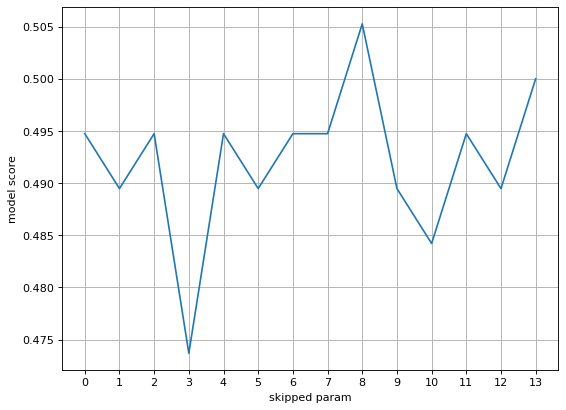

In [202]:

scores=[]
skipped_params=[]
names_len=len(names)
for i in range(names_len):
    name=names.pop(0)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True, local_names=names))
    names.append(name)
    skipped_params.append(name)
    print('\nskipped ', name)
    #AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(ticks=np.arange(len(skipped_params)))
plt.grid()
plt.plot(scores)

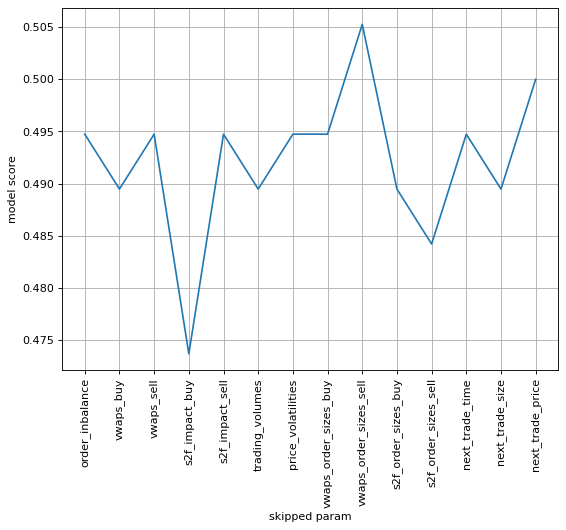

In [203]:
### FEATURE DROPPED ON X AXIS
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='vertical')
plt.grid()
plt.plot(scores)

# Decision trees classification

In [125]:
def test_decision_trees_classic(X, y, split_percent, epsilon, 
                               use_scaling=False, 
                               test_min_max = 'max'):
    if test_min_max == 'max':
        y=np.vectorize(test_high)(y,epsilon*y[0])#currently we hold price change in y
    elif test_min_max == 'min':
        y=np.vectorize(test_down)(y,epsilon*y[0])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier(random_state=0)).fit(X[:split], y[:split])
    else:
        clf = DecisionTreeClassifier(random_state=0).fit(X[:split], y[:split])
    y_predicted=clf.predict(X[split:])
    print("Number of positive class in training dataset =", np.sum(y[:split]==1))
    print("Number of negative class in training dataset =", np.sum(y[:split]==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y[split:])/len(y_predicted))
    print("Confusion matrix:")
    print(confusion_matrix(y[split:], y_predicted))
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty

Epsilon =  0.0
Number of positive class in training dataset = 155
Number of negative class in training dataset = 605
Percent of correct classification:
0.6473684210526316
Confusion matrix:
[[115  32]
 [ 35   8]]

Epsilon =  0.001
Number of positive class in training dataset = 155
Number of negative class in training dataset = 605
Percent of correct classifi

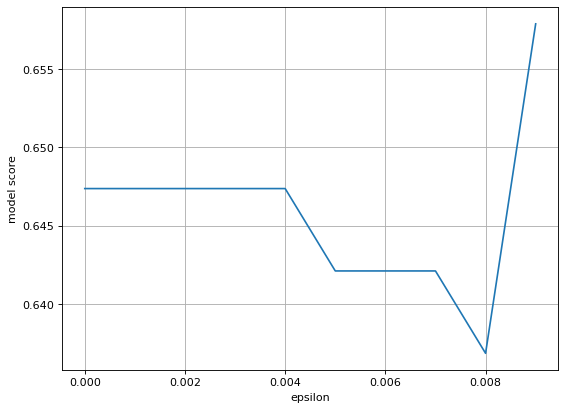

In [136]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
period_of_getting_data_to_test = 30
y_name='true_price'
test_min_max = 'min'
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0,0.01, 0.001)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_decision_trees_classic(X, np.copy(y),split_percent, epsilon, False, test_min_max))
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

In [143]:
xd = np.arange(3)
xdd = np.arange(3)
print(np.concatenate((xd, xdd)))

[0 1 2 0 1 2]


In [147]:
xd

array([0, 1, 2])

In [148]:
np.concatenate((xd[:0], xd[1:]))

array([1, 2])

### Try cross validation

In [222]:
def cross_validation(X, y, model, num_of_day = 10):
    num_of_samples_in_day = X.shape[0]//num_of_day
    plot_indicators = np.zeros(shape = (10, 3))
    for day in range(num_of_day):
        try:
            X_train = np.concatenate((X[:day*num_of_samples_in_day], X[(day+1)*num_of_samples_in_day:]))
            y_train = np.concatenate((y[:day*num_of_samples_in_day], y[(day+1)*num_of_samples_in_day:]))
            X_test = X[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            y_test = y[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            if model == 'log_reg':
                score, precision, recall = test_logistic_regr_classic_cross_val(X_train, y_train, X_test, y_test, use_scaling=True, local_names=names,track_params=False)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'xgb':
                score, precision, recall = test_xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling=True)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
        except ValueError as err:
            plot_indicators[day][0] = math.nan
            plot_indicators[day][1] = math.nan
            plot_indicators[day][2] = math.nan
            print(err)
    return plot_indicators

In [219]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 180
test_min_max = 'max'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold_plots = []
thresholds = np.geomspace(1e-2, 1e-9, num = 8)
for threshold in range(thresholds.size):
        print("Threshold = ", thresholds[threshold])
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        threshold_plots.append(cross_validation(X, y, 'log_reg'))

Threshold =  0.01
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
order_inbalance   -1.8537360130658797e-06
vwaps_buy   -4.42752208246891e-06
vwaps_sell   -5.124052309633264e-06
s2f_impact_buy   -1.7470795170637565e-06
s2f_impact_sell   -1.3273692235550696e-06
trading_volumes   -5.3527534490774866e-05
price_volatilities   1.4606539783672846e-07
vwaps_order_sizes_buy   -1.1123442

<ipython-input-187-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-187-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])



Precision:
0.0
Recall:
nan
Coefficient impact:
order_inbalance   -2.3667499861072572e-06
vwaps_buy   -2.6435219718893802e-05
vwaps_sell   -3.166416748537262e-05
s2f_impact_buy   -2.940143964328266e-06
s2f_impact_sell   -1.1069404521042563e-06
trading_volumes   -4.462756693340901e-05
price_volatilities   1.4926567512751964e-07
vwaps_order_sizes_buy   -1.7985889223294497e-05
vwaps_order_sizes_sell   -8.401223082668083e-06
s2f_order_sizes_buy   -9.44794099317364e-05
s2f_order_sizes_sell   -0.00016937987168603387
next_trade_time   0.000596513178957669
next_trade_size   -0.002253682510857337
next_trade_price   -6.45032698611613e-05
Number of positive class in training dataset = 79
Number of negative class in training dataset = 776
Number of positive class in testing dataset = 16
Number of negative class in testing dataset = 79
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[ 0 16]
 [ 0 79]]
Precision:
0.0
Recall:
nan
Coefficient impact:
order_inbalance   -3.259195

<ipython-input-187-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
<ipython-input-187-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


Coefficient impact:
order_inbalance   -3.7320911161233252e-06
vwaps_buy   -2.345100624696138e-05
vwaps_sell   -1.1449777839850224e-05
s2f_impact_buy   -1.789694834572398e-06
s2f_impact_sell   -1.7509657712246893e-06
trading_volumes   -5.2938796506719264e-05
price_volatilities   1.41090538704203e-07
vwaps_order_sizes_buy   -8.898041373689897e-05
vwaps_order_sizes_sell   -1.8296439449301024e-05
s2f_order_sizes_buy   -0.00023973882933530217
s2f_order_sizes_sell   -0.00013581514780948396
next_trade_time   0.0005246116010958987
next_trade_size   -0.001339972974289462
next_trade_price   -4.6215332883913574e-05
Number of positive class in training dataset = 64
Number of negative class in training dataset = 791
Number of positive class in testing dataset = 31
Number of negative class in testing dataset = 64
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[ 0 31]
 [ 0 64]]
Precision:
0.0
Recall:
nan
Coefficient impact:
order_inbalance   -8.42743468100109e-07
vwaps_buy  

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-187-7ba136a4f916>:39: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])


Coefficient impact:
order_inbalance   -0.08826268040609
vwaps_buy   0.21951476279119614
vwaps_sell   0.30703236343771906
s2f_impact_buy   -0.6767898356048632
s2f_impact_sell   -0.4203718869098382
trading_volumes   -7.182040772411654e-06
price_volatilities   0.0005456768762925209
vwaps_order_sizes_buy   9.886643313052515e-06
vwaps_order_sizes_sell   -3.2865136934508903e-06
s2f_order_sizes_buy   9.910291361178231e-05
s2f_order_sizes_sell   -7.374029934325184e-07
next_trade_time   0.00037990044477156037
next_trade_size   -0.00034311284066896626
next_trade_price   -0.23059247213092177
Number of positive class in training dataset = 87
Number of negative class in training dataset = 768
Number of positive class in testing dataset = 8
Number of negative class in testing dataset = 87
Percent of correct classification:
0.9157894736842105
Confusion matrix:
[[ 0  8]
 [ 0 87]]
Precision:
0.0
Recall:
nan
Coefficient impact:
order_inbalance   -2.889244789671854e-06
vwaps_buy   -2.8838894055485303e-05

Coefficient impact:
order_inbalance   1.2839937132894994e-05
vwaps_buy   4.116520159168867e-05
vwaps_sell   0.00011803669592187001
s2f_impact_buy   5.478961421120667e-06
s2f_impact_sell   4.386663436652797e-06
trading_volumes   -7.515276275683911e-06
price_volatilities   -6.640776827196286e-08
vwaps_order_sizes_buy   3.6429239497382293e-06
vwaps_order_sizes_sell   3.031698970666501e-05
s2f_order_sizes_buy   2.1881871231215236e-05
s2f_order_sizes_sell   5.235886947472245e-05
next_trade_time   0.004597357785760423
next_trade_size   0.0007608521127643556
next_trade_price   0.0001616366723843941
Number of positive class in training dataset = 645
Number of negative class in training dataset = 210
Number of positive class in testing dataset = 63
Number of negative class in testing dataset = 32
Percent of correct classification:
0.6631578947368421
Confusion matrix:
[[63  0]
 [32  0]]
Precision:
1.0
Recall:
0.6631578947368421
Coefficient impact:
order_inbalance   1.23867401931334e-05
vwaps_buy

Coefficient impact:
order_inbalance   0.020859267752047495
vwaps_buy   0.0040343572943601705
vwaps_sell   0.11050946532794981
s2f_impact_buy   0.0145391575154994
s2f_impact_sell   0.007908854924041569
trading_volumes   -2.497867119101185e-06
price_volatilities   -0.18712336539570523
vwaps_order_sizes_buy   9.554626190670184e-06
vwaps_order_sizes_sell   9.580093963922755e-06
s2f_order_sizes_buy   6.16109262850279e-05
s2f_order_sizes_sell   6.47859059343839e-05
next_trade_time   0.002508297739325098
next_trade_size   0.0005850200034370054
next_trade_price   0.123665525750355
Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[77  1]
 [16  1]]
Precision:
0.9871794871794872
Recall:
0.8279569892473119
Coefficient impact:
order_inbalance   2.8097994550191513e-05
vwaps_buy  

Coefficient impact:
order_inbalance   3.283882395047984e-05
vwaps_buy   0.00016364018094171758
vwaps_sell   0.00022762420774460188
s2f_impact_buy   1.6606023834188654e-05
s2f_impact_sell   9.552526377105915e-06
trading_volumes   -1.1073056425599116e-05
price_volatilities   -1.0306503118999663e-07
vwaps_order_sizes_buy   1.683025767915392e-05
vwaps_order_sizes_sell   3.5770123404535944e-05
s2f_order_sizes_buy   5.600660558727137e-05
s2f_order_sizes_sell   0.000114494840456441
next_trade_time   0.0065107466837601834
next_trade_size   0.0013432952088552623
next_trade_price   0.00040049786583448466
Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[72  0]
 [23  0]]
Precision:
1.0
Recall:
0.7578947368421053
Coefficient impact:
order_inbalance   2.6854318546046627e-05
vwap

Coefficient impact:
order_inbalance   2.6854318546046627e-05
vwaps_buy   0.00010552488381160223
vwaps_sell   0.00015589373902918333
s2f_impact_buy   1.1442232416095568e-05
s2f_impact_sell   6.887676868167437e-06
trading_volumes   -9.980171388177367e-06
price_volatilities   -1.232691474187727e-07
vwaps_order_sizes_buy   2.0223127294214e-05
vwaps_order_sizes_sell   3.054661422956646e-05
s2f_order_sizes_buy   5.3790285109009865e-05
s2f_order_sizes_sell   9.601534834838481e-05
next_trade_time   0.0041532481898497
next_trade_size   0.0013477531939912375
next_trade_price   0.0002675540305206259
Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.9052631578947369
Confusion matrix:
[[86  0]
 [ 9  0]]
Precision:
1.0
Recall:
0.9052631578947369
Threshold =  1e-07
22.34375% of intervals were SELL empty
23.4375% of in

Coefficient impact:
order_inbalance   2.6854318546046627e-05
vwaps_buy   0.00010552488381160223
vwaps_sell   0.00015589373902918333
s2f_impact_buy   1.1442232416095568e-05
s2f_impact_sell   6.887676868167437e-06
trading_volumes   -9.980171388177367e-06
price_volatilities   -1.232691474187727e-07
vwaps_order_sizes_buy   2.0223127294214e-05
vwaps_order_sizes_sell   3.054661422956646e-05
s2f_order_sizes_buy   5.3790285109009865e-05
s2f_order_sizes_sell   9.601534834838481e-05
next_trade_time   0.0041532481898497
next_trade_size   0.0013477531939912375
next_trade_price   0.0002675540305206259
Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.9052631578947369
Confusion matrix:
[[86  0]
 [ 9  0]]
Precision:
1.0
Recall:
0.9052631578947369
Threshold =  1e-08
22.34375% of intervals were SELL empty
23.4375% of in

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
Coefficient impact:
order_inbalance   2.2481986398597304e-05
vwaps_buy   6.641734184389569e-05
vwaps_sell   0.00014285466178259155
s2f_impact_buy   6.85613122462062e-06
s2f_impact_sell   5.449435946059332e-06
trading_volumes   -8.698419291840662e-06
price_volatilities   -1.2925050156811504e-07
vwaps_order_sizes_buy   1.531250831161962e-05
vwaps_order_

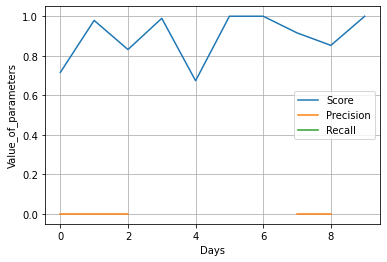

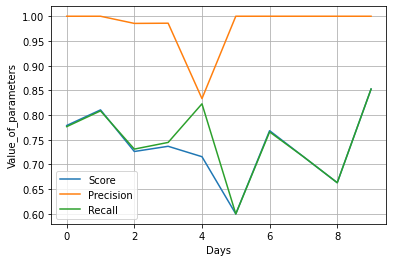

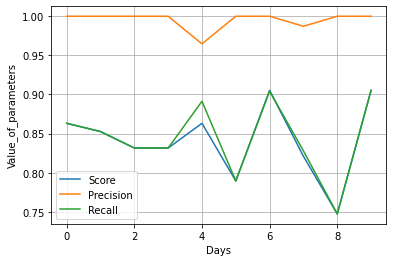

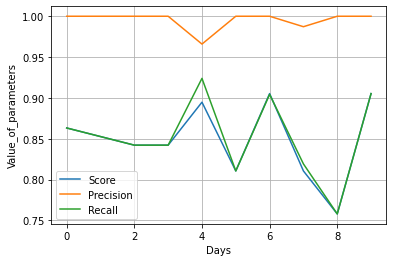

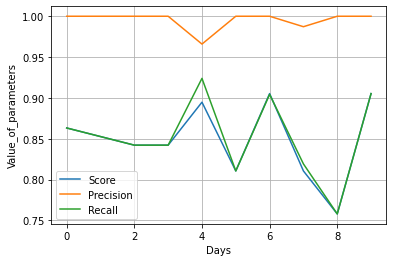

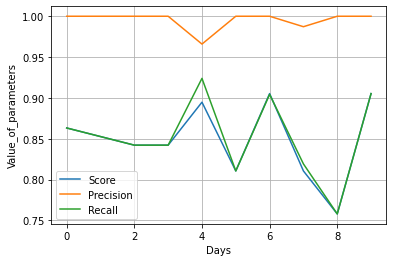

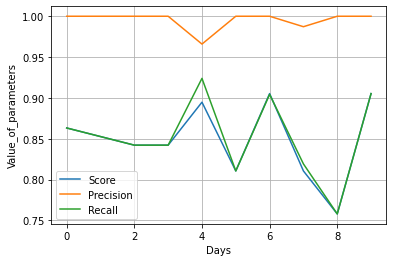

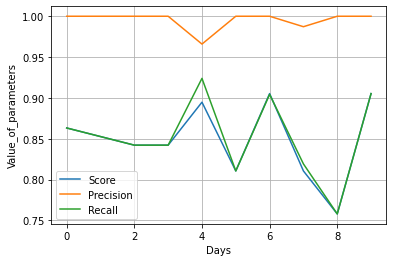

In [220]:
#figure(figsize=(8, 6), dpi=80)
counter = 0
for threshold in thresholds:
    plt.title("Plot of Score, precision and recall given threshold: {}".format(threshold))
    plt.axes(xlabel='Days', ylabel='Value_of_parameters')
    #plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
    plt.grid()
    for i in range(3):
        plt.plot(threshold_plots[counter][:,i])
    plt.legend(["Score", "Precision", "Recall"])
    plt.show()
    counter +=1

In [201]:
threshold_plots[3]

array([[0.74736842, 1.        , 0.74736842],
       [0.73684211, 0.98591549, 0.74468085],
       [0.73684211, 0.98591549, 0.74468085],
       [0.78947368, 0.98684211, 0.79787234],
       [0.88421053, 0.97674419, 0.90322581],
       [0.77894737, 1.        , 0.77894737],
       [0.78947368, 1.        , 0.78947368],
       [0.76842105, 0.97297297, 0.7826087 ],
       [0.67368421, 1.        , 0.67368421],
       [0.87368421, 1.        , 0.87368421]])

In [202]:
threshold_plots[4]

array([[0.74736842, 1.        , 0.74736842],
       [0.73684211, 0.98591549, 0.74468085],
       [0.73684211, 0.98591549, 0.74468085],
       [0.78947368, 0.98684211, 0.79787234],
       [0.88421053, 0.97674419, 0.90322581],
       [0.77894737, 1.        , 0.77894737],
       [0.78947368, 1.        , 0.78947368],
       [0.76842105, 0.97297297, 0.7826087 ],
       [0.67368421, 1.        , 0.67368421],
       [0.87368421, 1.        , 0.87368421]])

# XGBOOST

In [225]:
def test_xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBClassifier(max_depth=3, scale_pos_weight=neg_class_count/pos_class_count)).fit(X_train, y_train)
    else:
        clf = xgb.XGBClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [226]:
comp_id = 1
interval=5
time_to_skip=30
time_back=1
y_name='true_price'
period_of_getting_data_to_test = 180
test_min_max = 'max'
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold_plots = []
thresholds = np.geomspace(1e-2, 1e-9, num = 8)
for threshold in range(thresholds.size):
        print("Threshold = ", thresholds[threshold])
        X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, period_of_getting_data_to_test, names, y_name, test_min_max, thresholds[threshold])
        threshold_plots.append(cross_validation(X, y, 'xgb'))

Threshold =  0.01
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 68
Number of negative class in training dataset = 787
Number of positive class in testing dataset = 27
Number of negative class in testing dataset = 68
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[ 2 25]
 [ 6 62]]
Precision:
0.07407407407407407
Recall:
0.25
[15:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 93
Number of negative class in training dataset = 762
Number of positive class in testing dataset = 2
Number of negative class in testing dataset = 93
Percent of correct classification:
0.8947368421052632
Confusion matrix:
[[ 0  2]
 [ 8 85]]
Precision:
0.0
Recall:
0.0
[15:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 79
Number of negative class in training dataset = 776
Number of positive class in testing dataset = 16
Number of negative class in testing dataset = 79
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[ 0 16]
 [ 4 75]]
Precision:
0.0
Recall:
0.0
[15:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
0.8842105263157894
Confusion matrix:
[[ 0  0]
 [11 84]]
[15:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 64
Number of negative class in training dataset = 791
Number of positive class in testing dataset = 31
Number of negative class in testing dataset = 64
Percent of correct classification:
0.7157894736842105
Confusion matrix:
[[ 4 27]
 [ 0 64]]
Precision:
0.12903225806451613
Recall:
1.0
[15:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
0.9052631578947369
Confusion matrix:
[[ 0  0]
 [ 9 86]]
[15:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
1.0
Confusion matrix:
[[ 0  0]
 [ 0 95]]
[15:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 87
Number of negative class in training dataset = 768
Number of positive class in testing dataset = 8
Number of negative class in testing dataset = 87
Percent of correct classification:
0.8736842105263158
Confusion matrix:
[[ 0  8]
 [ 4 83]]
Precision:
0.0
Recall:
0.0
[15:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 84
Number of negative class in training dataset = 771
Number of positive class in testing dataset = 11
Number of negative class in testing dataset = 84
Percent of correct classification:
0.8210526315789474
Confusion matrix:
[[ 0 11]
 [ 6 78]]
Precision:
0.0
Recall:
0.0
[15:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 95
Number of negative class in training dataset = 760
Number of positive class in testing dataset = 0
Number of negative class in testing dataset = 95
Percent of correct classification:
0.8842105263157894
Confusion matrix:
[[ 0  0]
 [11 84]]
Threshold =  0.001
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 635
Number of negative class in training dataset = 220
Number of positive class in testing dataset = 73
Number of negative class in testing dataset = 22
Percent of correct classification:
0.631578947368421
Confusion matrix:
[[48 25]
 [10 12]]
Precision:
0.6575342465753424
Recall:
0.8275862068965517


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 632
Number of negative class in training dataset = 223
Number of positive class in testing dataset = 76
Number of negative class in testing dataset = 19
Percent of correct classification:
0.5263157894736842
Confusion matrix:
[[42 34]
 [11  8]]
Precision:
0.5526315789473685
Recall:
0.7924528301886793
[15:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 639
Number of negative class in training dataset = 216
Number of positive class in testing dataset = 69
Number of negative class in testing dataset = 26
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[62  7]
 [21  5]]
Precision:
0.8985507246376812
Recall:
0.7469879518072289
[15:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 637
Number of negative class in training dataset = 218
Number of positive class in testing dataset = 71
Number of negative class in testing dataset = 24
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[57 14]
 [17  7]]
Precision:
0.8028169014084507
Recall:
0.7702702702702703
[15:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 630
Number of negative class in training dataset = 225
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.4842105263157895
Confusion matrix:
[[34 44]
 [ 5 12]]
Precision:
0.4358974358974359
Recall:
0.8717948717948718
[15:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 651
Number of negative class in training dataset = 204
Number of positive class in testing dataset = 57
Number of negative class in testing dataset = 38
Percent of correct classification:
0.5684210526315789
Confusion matrix:
[[46 11]
 [30  8]]
Precision:
0.8070175438596491
Recall:
0.6052631578947368
[15:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 636
Number of negative class in training dataset = 219
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.47368421052631576
Confusion matrix:
[[36 36]
 [14  9]]
Precision:
0.5
Recall:
0.72
[15:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 640
Number of negative class in training dataset = 215
Number of positive class in testing dataset = 68
Number of negative class in testing dataset = 27
Percent of correct classification:
0.631578947368421
Confusion matrix:
[[51 17]
 [18  9]]
Precision:
0.75
Recall:
0.7391304347826086
[15:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 645
Number of negative class in training dataset = 210
Number of positive class in testing dataset = 63
Number of negative class in testing dataset = 32
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[56  7]
 [26  6]]
Precision:
0.8888888888888888
Recall:
0.6829268292682927
[15:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 627
Number of negative class in training dataset = 228
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6736842105263158
Confusion matrix:
[[59 22]
 [ 9  5]]
Precision:
0.7283950617283951
Recall:
0.8676470588235294
Threshold =  0.0001
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)
[15:01:43] WARNING: C:/Users/Ad

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Precision:
0.8536585365853658
Recall:
0.8974358974358975
[15:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 720
Number of negative class in training dataset = 135
Number of positive class in testing dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[53 28]
 [ 9  5]]
Precision:
0.654320987654321
Recall:
0.8548387096774194
[15:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 722
Number of negative class in training dataset = 133
Number of positive class in testing dataset = 79
Number of negative class in testing dataset = 16
Percent of correct classification:
0.8105263157894737
Confusion matrix:
[[74  5]
 [13  3]]
Precision:
0.9367088607594937
Recall:
0.8505747126436781
[15:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 722
Number of negative class in training dataset = 133
Number of positive class in testing dataset = 79
Number of negative class in testing dataset = 16
Percent of correct classification:
0.7789473684210526
Confusion matrix:
[[71  8]
 [13  3]]
Precision:
0.8987341772151899
Recall:
0.8452380952380952
[15:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 716
Number of negative class in training dataset = 139
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[52 33]
 [ 4  6]]
Precision:
0.611764705882353
Recall:
0.9285714285714286
[15:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 726
Number of negative class in training dataset = 129
Number of positive class in testing dataset = 75
Number of negative class in testing dataset = 20
Percent of correct classification:
0.6842105263157895
Confusion matrix:
[[63 12]
 [18  2]]
Precision:
0.84
Recall:
0.7777777777777778
[15:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 716
Number of negative class in training dataset = 139
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6
Confusion matrix:
[[56 29]
 [ 9  1]]
Precision:
0.6588235294117647
Recall:
0.8615384615384616
[15:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_re

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7368421052631579
Confusion matrix:
[[64 14]
 [11  6]]
Precision:
0.8205128205128205
Recall:
0.8533333333333334
[15:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 730
Number of negative class in training dataset = 125
Number of positive class in testing dataset = 71
Number of negative class in testing dataset = 24
Percent of correct classification:
0.7473684210526316
Confusion matrix:
[[67  4]
 [20  4]]
Precision:
0.9436619718309859
Recall:
0.7701149425287356
[15:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 715
Number of negative class in training dataset = 140
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.7894736842105263
Confusion matrix:
[[72 14]
 [ 6  3]]
Precision:
0.8372093023255814
Recall:
0.9230769230769231
Threshold =  1e-05
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in trai

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-06
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in trai

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 721


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-07
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
(950,)


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in trai

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset = 731


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-08
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024
Threshold =  1e-09
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY 

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 727
Number of negative class in training dataset = 128
Number of positive class in testing dataset = 82
Number of negative class in testing dataset = 13
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[67 15]
 [ 7  6]]
Precision:
0.8170731707317073
Recall:
0.9054054054054054
[15:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 728
Number of negative class in training dataset = 127
Number of positive class in testing dataset = 81
Number of negative class in testing dataset = 14
Percent of correct classification:
0.6526315789473685
Confusion matrix:
[[58 23]
 [10  4]]
Precision:
0.7160493827160493
Recall:
0.8529411764705882
[15:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.8315789473684211
Confusion matrix:
[[76  4]
 [12  3]]
Precision:
0.95
Recall:
0.8636363636363636
[15:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 729
Number of negative class in training dataset = 126
Number of positive class in testing dataset = 80
Number of negative class in testing dataset = 15
Percent of correct classification:
0.7684210526315789
Confusion matrix:
[[70 10]
 [12  3]]
Precision:
0.875
Recall:
0.8536585365853658
[15:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 721
Number of negative class in training dataset = 134
Number of positive class in testing dataset = 88
Number of negative class in testing dataset = 7
Percent of correct classification:
0.5894736842105263
Confusion matrix:
[[52 36]
 [ 3  4]]
Precision:
0.5909090909090909
Recall:
0.9454545454545454
[15:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 732
Number of negative class in training dataset = 123
Number of positive class in testing dataset = 77
Number of negative class in testing dataset = 18
Percent of correct classification:
0.7052631578947368
Confusion matrix:
[[65 12]
 [16  2]]
Precision:
0.8441558441558441
Recall:
0.8024691358024691
[15:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 724
Number of negative class in training dataset = 131
Number of positive class in testing dataset = 85
Number of negative class in testing dataset = 10
Percent of correct classification:
0.6105263157894737
Confusion matrix:
[[56 29]
 [ 8  2]]
Precision:
0.6588235294117647
Recall:
0.875
[15:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of positive class in training dataset =

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 731
Number of negative class in training dataset = 124
Number of positive class in testing dataset = 78
Number of negative class in testing dataset = 17
Percent of correct classification:
0.7263157894736842
Confusion matrix:
[[63 15]
 [11  6]]
Precision:
0.8076923076923077
Recall:
0.8513513513513513
[15:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 737
Number of negative class in training dataset = 118
Number of positive class in testing dataset = 72
Number of negative class in testing dataset = 23
Percent of correct classification:
0.7578947368421053
Confusion matrix:
[[68  4]
 [19  4]]
Precision:
0.9444444444444444
Recall:
0.7816091954022989
[15:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Number of positive class in training dataset = 723
Number of negative class in training dataset = 132
Number of positive class in testing dataset = 86
Number of negative class in testing dataset = 9
Percent of correct classification:
0.8526315789473684
Confusion matrix:
[[77  9]
 [ 5  4]]
Precision:
0.8953488372093024
Recall:
0.9390243902439024


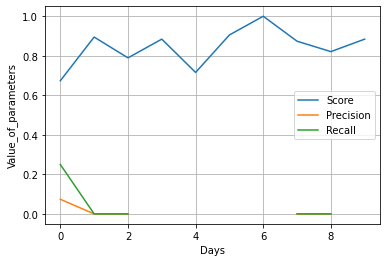

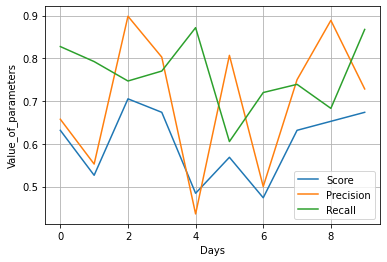

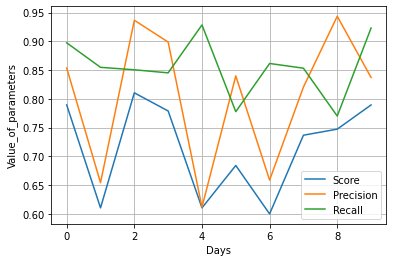

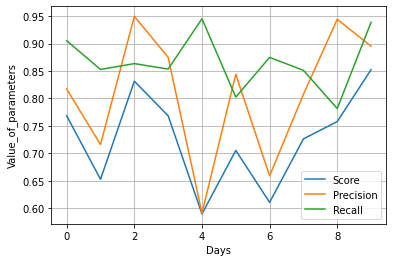

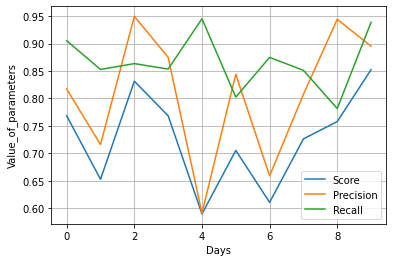

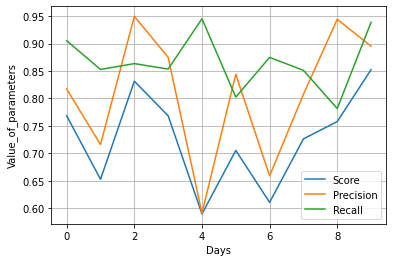

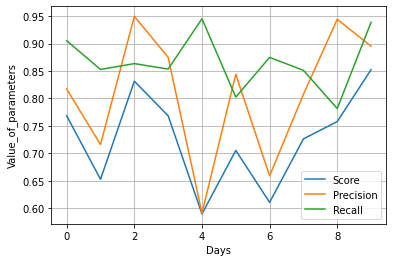

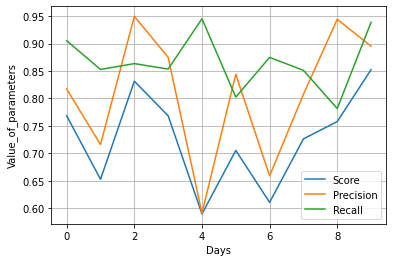

In [227]:
#figure(figsize=(8, 6), dpi=80)
counter = 0
for threshold in thresholds:
    plt.title("Plot of Score, precision and recall given threshold: {}".format(threshold))
    plt.axes(xlabel='Days', ylabel='Value_of_parameters')
    #plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
    plt.grid()
    for i in range(3):
        plt.plot(threshold_plots[counter][:,i])
    plt.legend(["Score", "Precision", "Recall"])
    plt.show()
    counter +=1